# Run torsion scans

In [1]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy

logger = logging.getLogger()
logger.setLevel(logging.INFO)


DEBUG:matplotlib:(private) matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warn

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


### Define helper function for running short MD

In [2]:
def run_md(htf, endstate):

    # Define simulation parameters
    temperature = 300 * unit.kelvin
    nsteps = 10000
    timestep = 4.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions

    # Create CompoundThermodynamicState at the appropriate endstate
    lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
    lambda_protocol = LambdaProtocol(functions = 'default')
    lambda_alchemical_state.set_alchemical_parameters(endstate, lambda_protocol)
    thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = thermodynamic_state.create_context(integrator, platform=platform)    
#     context, integrator = cache.global_context_cache.get_context(thermodynamic_state, integrator)
#     print(context.getParameter('lambda_angles'))
        
    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(thermodynamic_state.reduced_potential(context))
    
    md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")


    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

    # Run equilibration
    for step in tqdm(range(nsteps)):
        integrator.step(1)
    
    return context, thermodynamic_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [4]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
#     d_masses = {}
#     # Set particle masses to 0
#     for index in hybrid_indices:
#         d_masses[index] = htf.hybrid_system.getParticleMass(index)
#         htf.hybrid_system.setParticleMass(index, 0.0)
    
#     # Turn off constraints involving massless particles
#     for i in reversed(range(htf.hybrid_system.getNumConstraints())):
#         p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
#         if p1 in hybrid_indices or p2 in hybrid_indices:
#             if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
#                 htf.hybrid_system.removeConstraint(i)
    
    # Run MD
    context, thermodynamic_state = run_md(htf, endstate)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(thermodynamic_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(thermodynamic_state, sampler_state)
        
        sampler_state.apply_to_context(context)
#         openmm.LocalEnergyMinimizer.minimize(context)
        energy = thermodynamic_state.reduced_potential(context)
        energies = [energy]
#         sampler_state.update_from_context(context)
        
#         # Apply relaxation move 3x
#         energies = []
#         for i in range(3):
#             relax_move = LangevinSplittingDynamicsMove(timestep=2.0*unit.femtoseconds, collision_rate=1.0/unit.picoseconds, n_steps=10000)
#             relax_move.apply(thermodynamic_state, sampler_state)
#             sampler_state.apply_to_context(context)
#             energy = thermodynamic_state.reduced_potential(context)
#             energies.append(energy)
#             positions = sampler_state.positions

    
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
#     # Set masses back to normal
#     for index in hybrid_indices:
#         thermodynamic_state.system.setParticleMass(index, d_masses[index])
#     thermodynamic_state.apply_to_context(context)
    
    return d_corrected
    
    

In [6]:
torsion_scans = []

### Generate torsion scans for the apo htf with flattened torsions and exceptions: T42A

In [19]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/11/" # 10 ns eq, 2 ns neq
with open(os.path.join(outdir, "11_apo.pickle" ), "rb") as f:
    htf_ta = pickle.load(f)

#### Look at hybrid and vanilla topologies to determine indices

In [7]:
for atom in htf_ta.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
LYS1-N 6
LYS1-CA 7
LYS1-C 8
LYS1-O 9
LYS1-CB 10
LYS1-CG 11
LYS1-CD 12
LYS1-CE 13
LYS1-NZ 14
LYS1-H2 15
LYS1-HA 16
LYS1-HB3 17
LYS1-HB2 18
LYS1-HG2 19
LYS1-HG3 20
LYS1-HD2 21
LYS1-HD3 22
LYS1-HE3 23
LYS1-HE2 24
LYS1-HZ1 25
LYS1-HZ2 26
LYS1-HZ3 27
LYS2-N 28
LYS2-CA 29
LYS2-C 30
LYS2-O 31
LYS2-CB 32
LYS2-CG 33
LYS2-CD 34
LYS2-CE 35
LYS2-NZ 36
LYS2-H 37
LYS2-HA 38
LYS2-HB3 39
LYS2-HB2 40
LYS2-HG2 41
LYS2-HG3 42
LYS2-HD3 43
LYS2-HD2 44
LYS2-HE3 45
LYS2-HE2 46
LYS2-HZ1 47
LYS2-HZ2 48
LYS2-HZ3 49
ALA3-N 50
ALA3-CA 51
ALA3-C 52
ALA3-O 53
ALA3-CB 54
ALA3-H 55
ALA3-HA 56
ALA3-HB1 57
ALA3-HB2 58
ALA3-HB3 59
VAL4-N 60
VAL4-CA 61
VAL4-C 62
VAL4-O 63
VAL4-CB 64
VAL4-CG1 65
VAL4-CG2 66
VAL4-H 67
VAL4-HA 68
VAL4-HB 69
VAL4-HG11 70
VAL4-HG12 71
VAL4-HG13 72
VAL4-HG21 73
VAL4-HG22 74
VAL4-HG23 75
ILE5-N 76
ILE5-CA 77
ILE5-C 78
ILE5-O 79
ILE5-CB 80
ILE5-CG1 81
ILE5-CG2 82
ILE5-CD1 83
ILE5-H 84
ILE5-HA 85
ILE5-HB 86
ILE5-HG13 87
ILE5-HG12 88
ILE5-

HOH349-H2 2211
HOH350-O 2212
HOH350-H1 2213
HOH350-H2 2214
HOH351-O 2215
HOH351-H1 2216
HOH351-H2 2217
HOH352-O 2218
HOH352-H1 2219
HOH352-H2 2220
HOH353-O 2221
HOH353-H1 2222
HOH353-H2 2223
HOH354-O 2224
HOH354-H1 2225
HOH354-H2 2226
HOH355-O 2227
HOH355-H1 2228
HOH355-H2 2229
HOH356-O 2230
HOH356-H1 2231
HOH356-H2 2232
HOH357-O 2233
HOH357-H1 2234
HOH357-H2 2235
HOH358-O 2236
HOH358-H1 2237
HOH358-H2 2238
HOH359-O 2239
HOH359-H1 2240
HOH359-H2 2241
HOH360-O 2242
HOH360-H1 2243
HOH360-H2 2244
HOH361-O 2245
HOH361-H1 2246
HOH361-H2 2247
HOH362-O 2248
HOH362-H1 2249
HOH362-H2 2250
HOH363-O 2251
HOH363-H1 2252
HOH363-H2 2253
HOH364-O 2254
HOH364-H1 2255
HOH364-H2 2256
HOH365-O 2257
HOH365-H1 2258
HOH365-H2 2259
HOH366-O 2260
HOH366-H1 2261
HOH366-H2 2262
HOH367-O 2263
HOH367-H1 2264
HOH367-H2 2265
HOH368-O 2266
HOH368-H1 2267
HOH368-H2 2268
HOH369-O 2269
HOH369-H1 2270
HOH369-H2 2271
HOH370-O 2272
HOH370-H1 2273
HOH370-H2 2274
HOH371-O 2275
HOH371-H1 2276
HOH371-H2 2277
HOH372-O 2278
HOH

HOH1187-O 4711
HOH1187-H1 4712
HOH1187-H2 4713
HOH1188-O 4714
HOH1188-H1 4715
HOH1188-H2 4716
HOH1189-O 4717
HOH1189-H1 4718
HOH1189-H2 4719
HOH1190-O 4720
HOH1190-H1 4721
HOH1190-H2 4722
HOH1191-O 4723
HOH1191-H1 4724
HOH1191-H2 4725
HOH1192-O 4726
HOH1192-H1 4727
HOH1192-H2 4728
HOH1193-O 4729
HOH1193-H1 4730
HOH1193-H2 4731
HOH1194-O 4732
HOH1194-H1 4733
HOH1194-H2 4734
HOH1195-O 4735
HOH1195-H1 4736
HOH1195-H2 4737
HOH1196-O 4738
HOH1196-H1 4739
HOH1196-H2 4740
HOH1197-O 4741
HOH1197-H1 4742
HOH1197-H2 4743
HOH1198-O 4744
HOH1198-H1 4745
HOH1198-H2 4746
HOH1199-O 4747
HOH1199-H1 4748
HOH1199-H2 4749
HOH1200-O 4750
HOH1200-H1 4751
HOH1200-H2 4752
HOH1201-O 4753
HOH1201-H1 4754
HOH1201-H2 4755
HOH1202-O 4756
HOH1202-H1 4757
HOH1202-H2 4758
HOH1203-O 4759
HOH1203-H1 4760
HOH1203-H2 4761
HOH1204-O 4762
HOH1204-H1 4763
HOH1204-H2 4764
HOH1205-O 4765
HOH1205-H1 4766
HOH1205-H2 4767
HOH1206-O 4768
HOH1206-H1 4769
HOH1206-H2 4770
HOH1207-O 4771
HOH1207-H1 4772
HOH1207-H2 4773
HOH1208-O 477

HOH2020-O 7210
HOH2020-H1 7211
HOH2020-H2 7212
HOH2021-O 7213
HOH2021-H1 7214
HOH2021-H2 7215
HOH2022-O 7216
HOH2022-H1 7217
HOH2022-H2 7218
HOH2023-O 7219
HOH2023-H1 7220
HOH2023-H2 7221
HOH2024-O 7222
HOH2024-H1 7223
HOH2024-H2 7224
HOH2025-O 7225
HOH2025-H1 7226
HOH2025-H2 7227
HOH2026-O 7228
HOH2026-H1 7229
HOH2026-H2 7230
HOH2027-O 7231
HOH2027-H1 7232
HOH2027-H2 7233
HOH2028-O 7234
HOH2028-H1 7235
HOH2028-H2 7236
HOH2029-O 7237
HOH2029-H1 7238
HOH2029-H2 7239
HOH2030-O 7240
HOH2030-H1 7241
HOH2030-H2 7242
HOH2031-O 7243
HOH2031-H1 7244
HOH2031-H2 7245
HOH2032-O 7246
HOH2032-H1 7247
HOH2032-H2 7248
HOH2033-O 7249
HOH2033-H1 7250
HOH2033-H2 7251
HOH2034-O 7252
HOH2034-H1 7253
HOH2034-H2 7254
HOH2035-O 7255
HOH2035-H1 7256
HOH2035-H2 7257
HOH2036-O 7258
HOH2036-H1 7259
HOH2036-H2 7260
HOH2037-O 7261
HOH2037-H1 7262
HOH2037-H2 7263
HOH2038-O 7264
HOH2038-H1 7265
HOH2038-H2 7266
HOH2039-O 7267
HOH2039-H1 7268
HOH2039-H2 7269
HOH2040-O 7270
HOH2040-H1 7271
HOH2040-H2 7272
HOH2041-O 727

HOH2857-H1 9710
HOH2857-H2 9711
HOH2858-O 9712
HOH2858-H1 9713
HOH2858-H2 9714
HOH2859-O 9715
HOH2859-H1 9716
HOH2859-H2 9717
HOH2860-O 9718
HOH2860-H1 9719
HOH2860-H2 9720
HOH2861-O 9721
HOH2861-H1 9722
HOH2861-H2 9723
HOH2862-O 9724
HOH2862-H1 9725
HOH2862-H2 9726
HOH2863-O 9727
HOH2863-H1 9728
HOH2863-H2 9729
HOH2864-O 9730
HOH2864-H1 9731
HOH2864-H2 9732
HOH2865-O 9733
HOH2865-H1 9734
HOH2865-H2 9735
HOH2866-O 9736
HOH2866-H1 9737
HOH2866-H2 9738
HOH2867-O 9739
HOH2867-H1 9740
HOH2867-H2 9741
HOH2868-O 9742
HOH2868-H1 9743
HOH2868-H2 9744
HOH2869-O 9745
HOH2869-H1 9746
HOH2869-H2 9747
HOH2870-O 9748
HOH2870-H1 9749
HOH2870-H2 9750
HOH2871-O 9751
HOH2871-H1 9752
HOH2871-H2 9753
HOH2872-O 9754
HOH2872-H1 9755
HOH2872-H2 9756
HOH2873-O 9757
HOH2873-H1 9758
HOH2873-H2 9759
HOH2874-O 9760
HOH2874-H1 9761
HOH2874-H2 9762
HOH2875-O 9763
HOH2875-H1 9764
HOH2875-H2 9765
HOH2876-O 9766
HOH2876-H1 9767
HOH2876-H2 9768
HOH2877-O 9769
HOH2877-H1 9770
HOH2877-H2 9771
HOH2878-O 9772
HOH2878-H1 97

HOH3693-H2 12210
HOH3694-O 12211
HOH3694-H1 12212
HOH3694-H2 12213
HOH3695-O 12214
HOH3695-H1 12215
HOH3695-H2 12216
HOH3696-O 12217
HOH3696-H1 12218
HOH3696-H2 12219
HOH3697-O 12220
HOH3697-H1 12221
HOH3697-H2 12222
HOH3698-O 12223
HOH3698-H1 12224
HOH3698-H2 12225
HOH3699-O 12226
HOH3699-H1 12227
HOH3699-H2 12228
HOH3700-O 12229
HOH3700-H1 12230
HOH3700-H2 12231
HOH3701-O 12232
HOH3701-H1 12233
HOH3701-H2 12234
HOH3702-O 12235
HOH3702-H1 12236
HOH3702-H2 12237
HOH3703-O 12238
HOH3703-H1 12239
HOH3703-H2 12240
HOH3704-O 12241
HOH3704-H1 12242
HOH3704-H2 12243
HOH3705-O 12244
HOH3705-H1 12245
HOH3705-H2 12246
HOH3706-O 12247
HOH3706-H1 12248
HOH3706-H2 12249
HOH3707-O 12250
HOH3707-H1 12251
HOH3707-H2 12252
HOH3708-O 12253
HOH3708-H1 12254
HOH3708-H2 12255
HOH3709-O 12256
HOH3709-H1 12257
HOH3709-H2 12258
HOH3710-O 12259
HOH3710-H1 12260
HOH3710-H2 12261
HOH3711-O 12262
HOH3711-H1 12263
HOH3711-H2 12264
HOH3712-O 12265
HOH3712-H1 12266
HOH3712-H2 12267
HOH3713-O 12268
HOH3713-H1 12269


In [9]:
for atom in htf_ta._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (LYS)> 6
<Atom 7 (CA) of chain 0 residue 1 (LYS)> 7
<Atom 8 (C) of chain 0 residue 1 (LYS)> 8
<Atom 9 (O) of chain 0 residue 1 (LYS)> 9
<Atom 10 (CB) of chain 0 residue 1 (LYS)> 10
<Atom 11 (CG) of chain 0 residue 1 (LYS)> 11
<Atom 12 (CD) of chain 0 residue 1 (LYS)> 12
<Atom 13 (CE) of chain 0 residue 1 (LYS)> 13
<Atom 14 (NZ) of chain 0 residue 1 (LYS)> 14
<Atom 15 (H2) of chain 0 residue 1 (LYS)> 15
<Atom 16 (HA) of chain 0 residue 1 (LYS)> 16
<Atom 17 (HB3) of chain 0 residue 1 (LYS)> 17
<Atom 18 (HB2) of chain 0 residue 1 (LYS)> 18
<Atom 19 (HG2) of chain 0 residue 1 (LYS)> 19
<Atom 20 (HG3) of chain 0 residue 1 (LYS)> 20
<Atom 21 (HD2) of chain 0 residue 1 (LYS)> 21
<Atom 22 (HD3) of chain 0 res

<Atom 1698 (H2) of chain 2 residue 176 (HOH)> 1698
<Atom 1699 (O) of chain 2 residue 177 (HOH)> 1699
<Atom 1700 (H1) of chain 2 residue 177 (HOH)> 1700
<Atom 1701 (H2) of chain 2 residue 177 (HOH)> 1701
<Atom 1702 (O) of chain 2 residue 178 (HOH)> 1702
<Atom 1703 (H1) of chain 2 residue 178 (HOH)> 1703
<Atom 1704 (H2) of chain 2 residue 178 (HOH)> 1704
<Atom 1705 (O) of chain 2 residue 179 (HOH)> 1705
<Atom 1706 (H1) of chain 2 residue 179 (HOH)> 1706
<Atom 1707 (H2) of chain 2 residue 179 (HOH)> 1707
<Atom 1708 (O) of chain 2 residue 180 (HOH)> 1708
<Atom 1709 (H1) of chain 2 residue 180 (HOH)> 1709
<Atom 1710 (H2) of chain 2 residue 180 (HOH)> 1710
<Atom 1711 (O) of chain 2 residue 181 (HOH)> 1711
<Atom 1712 (H1) of chain 2 residue 181 (HOH)> 1712
<Atom 1713 (H2) of chain 2 residue 181 (HOH)> 1713
<Atom 1714 (O) of chain 2 residue 182 (HOH)> 1714
<Atom 1715 (H1) of chain 2 residue 182 (HOH)> 1715
<Atom 1716 (H2) of chain 2 residue 182 (HOH)> 1716
<Atom 1717 (O) of chain 2 residue 183

<Atom 3698 (H1) of chain 2 residue 843 (HOH)> 3698
<Atom 3699 (H2) of chain 2 residue 843 (HOH)> 3699
<Atom 3700 (O) of chain 2 residue 844 (HOH)> 3700
<Atom 3701 (H1) of chain 2 residue 844 (HOH)> 3701
<Atom 3702 (H2) of chain 2 residue 844 (HOH)> 3702
<Atom 3703 (O) of chain 2 residue 845 (HOH)> 3703
<Atom 3704 (H1) of chain 2 residue 845 (HOH)> 3704
<Atom 3705 (H2) of chain 2 residue 845 (HOH)> 3705
<Atom 3706 (O) of chain 2 residue 846 (HOH)> 3706
<Atom 3707 (H1) of chain 2 residue 846 (HOH)> 3707
<Atom 3708 (H2) of chain 2 residue 846 (HOH)> 3708
<Atom 3709 (O) of chain 2 residue 847 (HOH)> 3709
<Atom 3710 (H1) of chain 2 residue 847 (HOH)> 3710
<Atom 3711 (H2) of chain 2 residue 847 (HOH)> 3711
<Atom 3712 (O) of chain 2 residue 848 (HOH)> 3712
<Atom 3713 (H1) of chain 2 residue 848 (HOH)> 3713
<Atom 3714 (H2) of chain 2 residue 848 (HOH)> 3714
<Atom 3715 (O) of chain 2 residue 849 (HOH)> 3715
<Atom 3716 (H1) of chain 2 residue 849 (HOH)> 3716
<Atom 3717 (H2) of chain 2 residue 84

<Atom 5698 (O) of chain 2 residue 1510 (HOH)> 5698
<Atom 5699 (H1) of chain 2 residue 1510 (HOH)> 5699
<Atom 5700 (H2) of chain 2 residue 1510 (HOH)> 5700
<Atom 5701 (O) of chain 2 residue 1511 (HOH)> 5701
<Atom 5702 (H1) of chain 2 residue 1511 (HOH)> 5702
<Atom 5703 (H2) of chain 2 residue 1511 (HOH)> 5703
<Atom 5704 (O) of chain 2 residue 1512 (HOH)> 5704
<Atom 5705 (H1) of chain 2 residue 1512 (HOH)> 5705
<Atom 5706 (H2) of chain 2 residue 1512 (HOH)> 5706
<Atom 5707 (O) of chain 2 residue 1513 (HOH)> 5707
<Atom 5708 (H1) of chain 2 residue 1513 (HOH)> 5708
<Atom 5709 (H2) of chain 2 residue 1513 (HOH)> 5709
<Atom 5710 (O) of chain 2 residue 1514 (HOH)> 5710
<Atom 5711 (H1) of chain 2 residue 1514 (HOH)> 5711
<Atom 5712 (H2) of chain 2 residue 1514 (HOH)> 5712
<Atom 5713 (O) of chain 2 residue 1515 (HOH)> 5713
<Atom 5714 (H1) of chain 2 residue 1515 (HOH)> 5714
<Atom 5715 (H2) of chain 2 residue 1515 (HOH)> 5715
<Atom 5716 (O) of chain 2 residue 1516 (HOH)> 5716
<Atom 5717 (H1) of 

<Atom 8198 (H1) of chain 2 residue 2343 (HOH)> 8198
<Atom 8199 (H2) of chain 2 residue 2343 (HOH)> 8199
<Atom 8200 (O) of chain 2 residue 2344 (HOH)> 8200
<Atom 8201 (H1) of chain 2 residue 2344 (HOH)> 8201
<Atom 8202 (H2) of chain 2 residue 2344 (HOH)> 8202
<Atom 8203 (O) of chain 2 residue 2345 (HOH)> 8203
<Atom 8204 (H1) of chain 2 residue 2345 (HOH)> 8204
<Atom 8205 (H2) of chain 2 residue 2345 (HOH)> 8205
<Atom 8206 (O) of chain 2 residue 2346 (HOH)> 8206
<Atom 8207 (H1) of chain 2 residue 2346 (HOH)> 8207
<Atom 8208 (H2) of chain 2 residue 2346 (HOH)> 8208
<Atom 8209 (O) of chain 2 residue 2347 (HOH)> 8209
<Atom 8210 (H1) of chain 2 residue 2347 (HOH)> 8210
<Atom 8211 (H2) of chain 2 residue 2347 (HOH)> 8211
<Atom 8212 (O) of chain 2 residue 2348 (HOH)> 8212
<Atom 8213 (H1) of chain 2 residue 2348 (HOH)> 8213
<Atom 8214 (H2) of chain 2 residue 2348 (HOH)> 8214
<Atom 8215 (O) of chain 2 residue 2349 (HOH)> 8215
<Atom 8216 (H1) of chain 2 residue 2349 (HOH)> 8216
<Atom 8217 (H2) of

<Atom 10697 (H1) of chain 2 residue 3176 (HOH)> 10697
<Atom 10698 (H2) of chain 2 residue 3176 (HOH)> 10698
<Atom 10699 (O) of chain 2 residue 3177 (HOH)> 10699
<Atom 10700 (H1) of chain 2 residue 3177 (HOH)> 10700
<Atom 10701 (H2) of chain 2 residue 3177 (HOH)> 10701
<Atom 10702 (O) of chain 2 residue 3178 (HOH)> 10702
<Atom 10703 (H1) of chain 2 residue 3178 (HOH)> 10703
<Atom 10704 (H2) of chain 2 residue 3178 (HOH)> 10704
<Atom 10705 (O) of chain 2 residue 3179 (HOH)> 10705
<Atom 10706 (H1) of chain 2 residue 3179 (HOH)> 10706
<Atom 10707 (H2) of chain 2 residue 3179 (HOH)> 10707
<Atom 10708 (O) of chain 2 residue 3180 (HOH)> 10708
<Atom 10709 (H1) of chain 2 residue 3180 (HOH)> 10709
<Atom 10710 (H2) of chain 2 residue 3180 (HOH)> 10710
<Atom 10711 (O) of chain 2 residue 3181 (HOH)> 10711
<Atom 10712 (H1) of chain 2 residue 3181 (HOH)> 10712
<Atom 10713 (H2) of chain 2 residue 3181 (HOH)> 10713
<Atom 10714 (O) of chain 2 residue 3182 (HOH)> 10714
<Atom 10715 (H1) of chain 2 residu

<Atom 13197 (H2) of chain 2 residue 4009 (HOH)> 13197
<Atom 13198 (O) of chain 2 residue 4010 (HOH)> 13198
<Atom 13199 (H1) of chain 2 residue 4010 (HOH)> 13199
<Atom 13200 (H2) of chain 2 residue 4010 (HOH)> 13200
<Atom 13201 (O) of chain 2 residue 4011 (HOH)> 13201
<Atom 13202 (H1) of chain 2 residue 4011 (HOH)> 13202
<Atom 13203 (H2) of chain 2 residue 4011 (HOH)> 13203
<Atom 13204 (O) of chain 2 residue 4012 (HOH)> 13204
<Atom 13205 (H1) of chain 2 residue 4012 (HOH)> 13205
<Atom 13206 (H2) of chain 2 residue 4012 (HOH)> 13206
<Atom 13207 (O) of chain 2 residue 4013 (HOH)> 13207
<Atom 13208 (H1) of chain 2 residue 4013 (HOH)> 13208
<Atom 13209 (H2) of chain 2 residue 4013 (HOH)> 13209
<Atom 13210 (O) of chain 2 residue 4014 (HOH)> 13210
<Atom 13211 (H1) of chain 2 residue 4014 (HOH)> 13211
<Atom 13212 (H2) of chain 2 residue 4014 (HOH)> 13212
<Atom 13213 (O) of chain 2 residue 4015 (HOH)> 13213
<Atom 13214 (H1) of chain 2 residue 4015 (HOH)> 13214
<Atom 13215 (H2) of chain 2 residu

In [10]:
for atom in htf_ta._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (LYS)> 6
<Atom 7 (CA) of chain 0 residue 1 (LYS)> 7
<Atom 8 (C) of chain 0 residue 1 (LYS)> 8
<Atom 9 (O) of chain 0 residue 1 (LYS)> 9
<Atom 10 (CB) of chain 0 residue 1 (LYS)> 10
<Atom 11 (CG) of chain 0 residue 1 (LYS)> 11
<Atom 12 (CD) of chain 0 residue 1 (LYS)> 12
<Atom 13 (CE) of chain 0 residue 1 (LYS)> 13
<Atom 14 (NZ) of chain 0 residue 1 (LYS)> 14
<Atom 15 (H2) of chain 0 residue 1 (LYS)> 15
<Atom 16 (HA) of chain 0 residue 1 (LYS)> 16
<Atom 17 (HB3) of chain 0 residue 1 (LYS)> 17
<Atom 18 (HB2) of chain 0 residue 1 (LYS)> 18
<Atom 19 (HG2) of chain 0 residue 1 (LYS)> 19
<Atom 20 (HG3) of chain 0 residue 1 (LYS)> 20
<Atom 21 (HD2) of chain 0 residue 1 (LYS)> 21
<Atom 22 (HD3) of chain 0 res

<Atom 1817 (H2) of chain 2 residue 217 (HOH)> 1817
<Atom 1818 (O) of chain 2 residue 218 (HOH)> 1818
<Atom 1819 (H1) of chain 2 residue 218 (HOH)> 1819
<Atom 1820 (H2) of chain 2 residue 218 (HOH)> 1820
<Atom 1821 (O) of chain 2 residue 219 (HOH)> 1821
<Atom 1822 (H1) of chain 2 residue 219 (HOH)> 1822
<Atom 1823 (H2) of chain 2 residue 219 (HOH)> 1823
<Atom 1824 (O) of chain 2 residue 220 (HOH)> 1824
<Atom 1825 (H1) of chain 2 residue 220 (HOH)> 1825
<Atom 1826 (H2) of chain 2 residue 220 (HOH)> 1826
<Atom 1827 (O) of chain 2 residue 221 (HOH)> 1827
<Atom 1828 (H1) of chain 2 residue 221 (HOH)> 1828
<Atom 1829 (H2) of chain 2 residue 221 (HOH)> 1829
<Atom 1830 (O) of chain 2 residue 222 (HOH)> 1830
<Atom 1831 (H1) of chain 2 residue 222 (HOH)> 1831
<Atom 1832 (H2) of chain 2 residue 222 (HOH)> 1832
<Atom 1833 (O) of chain 2 residue 223 (HOH)> 1833
<Atom 1834 (H1) of chain 2 residue 223 (HOH)> 1834
<Atom 1835 (H2) of chain 2 residue 223 (HOH)> 1835
<Atom 1836 (O) of chain 2 residue 224

<Atom 3567 (O) of chain 2 residue 801 (HOH)> 3567
<Atom 3568 (H1) of chain 2 residue 801 (HOH)> 3568
<Atom 3569 (H2) of chain 2 residue 801 (HOH)> 3569
<Atom 3570 (O) of chain 2 residue 802 (HOH)> 3570
<Atom 3571 (H1) of chain 2 residue 802 (HOH)> 3571
<Atom 3572 (H2) of chain 2 residue 802 (HOH)> 3572
<Atom 3573 (O) of chain 2 residue 803 (HOH)> 3573
<Atom 3574 (H1) of chain 2 residue 803 (HOH)> 3574
<Atom 3575 (H2) of chain 2 residue 803 (HOH)> 3575
<Atom 3576 (O) of chain 2 residue 804 (HOH)> 3576
<Atom 3577 (H1) of chain 2 residue 804 (HOH)> 3577
<Atom 3578 (H2) of chain 2 residue 804 (HOH)> 3578
<Atom 3579 (O) of chain 2 residue 805 (HOH)> 3579
<Atom 3580 (H1) of chain 2 residue 805 (HOH)> 3580
<Atom 3581 (H2) of chain 2 residue 805 (HOH)> 3581
<Atom 3582 (O) of chain 2 residue 806 (HOH)> 3582
<Atom 3583 (H1) of chain 2 residue 806 (HOH)> 3583
<Atom 3584 (H2) of chain 2 residue 806 (HOH)> 3584
<Atom 3585 (O) of chain 2 residue 807 (HOH)> 3585
<Atom 3586 (H1) of chain 2 residue 807

<Atom 5566 (H1) of chain 2 residue 1467 (HOH)> 5566
<Atom 5567 (H2) of chain 2 residue 1467 (HOH)> 5567
<Atom 5568 (O) of chain 2 residue 1468 (HOH)> 5568
<Atom 5569 (H1) of chain 2 residue 1468 (HOH)> 5569
<Atom 5570 (H2) of chain 2 residue 1468 (HOH)> 5570
<Atom 5571 (O) of chain 2 residue 1469 (HOH)> 5571
<Atom 5572 (H1) of chain 2 residue 1469 (HOH)> 5572
<Atom 5573 (H2) of chain 2 residue 1469 (HOH)> 5573
<Atom 5574 (O) of chain 2 residue 1470 (HOH)> 5574
<Atom 5575 (H1) of chain 2 residue 1470 (HOH)> 5575
<Atom 5576 (H2) of chain 2 residue 1470 (HOH)> 5576
<Atom 5577 (O) of chain 2 residue 1471 (HOH)> 5577
<Atom 5578 (H1) of chain 2 residue 1471 (HOH)> 5578
<Atom 5579 (H2) of chain 2 residue 1471 (HOH)> 5579
<Atom 5580 (O) of chain 2 residue 1472 (HOH)> 5580
<Atom 5581 (H1) of chain 2 residue 1472 (HOH)> 5581
<Atom 5582 (H2) of chain 2 residue 1472 (HOH)> 5582
<Atom 5583 (O) of chain 2 residue 1473 (HOH)> 5583
<Atom 5584 (H1) of chain 2 residue 1473 (HOH)> 5584
<Atom 5585 (H2) of

<Atom 8066 (H2) of chain 2 residue 2300 (HOH)> 8066
<Atom 8067 (O) of chain 2 residue 2301 (HOH)> 8067
<Atom 8068 (H1) of chain 2 residue 2301 (HOH)> 8068
<Atom 8069 (H2) of chain 2 residue 2301 (HOH)> 8069
<Atom 8070 (O) of chain 2 residue 2302 (HOH)> 8070
<Atom 8071 (H1) of chain 2 residue 2302 (HOH)> 8071
<Atom 8072 (H2) of chain 2 residue 2302 (HOH)> 8072
<Atom 8073 (O) of chain 2 residue 2303 (HOH)> 8073
<Atom 8074 (H1) of chain 2 residue 2303 (HOH)> 8074
<Atom 8075 (H2) of chain 2 residue 2303 (HOH)> 8075
<Atom 8076 (O) of chain 2 residue 2304 (HOH)> 8076
<Atom 8077 (H1) of chain 2 residue 2304 (HOH)> 8077
<Atom 8078 (H2) of chain 2 residue 2304 (HOH)> 8078
<Atom 8079 (O) of chain 2 residue 2305 (HOH)> 8079
<Atom 8080 (H1) of chain 2 residue 2305 (HOH)> 8080
<Atom 8081 (H2) of chain 2 residue 2305 (HOH)> 8081
<Atom 8082 (O) of chain 2 residue 2306 (HOH)> 8082
<Atom 8083 (H1) of chain 2 residue 2306 (HOH)> 8083
<Atom 8084 (H2) of chain 2 residue 2306 (HOH)> 8084
<Atom 8085 (O) of 

<Atom 10566 (O) of chain 2 residue 3134 (HOH)> 10566
<Atom 10567 (H1) of chain 2 residue 3134 (HOH)> 10567
<Atom 10568 (H2) of chain 2 residue 3134 (HOH)> 10568
<Atom 10569 (O) of chain 2 residue 3135 (HOH)> 10569
<Atom 10570 (H1) of chain 2 residue 3135 (HOH)> 10570
<Atom 10571 (H2) of chain 2 residue 3135 (HOH)> 10571
<Atom 10572 (O) of chain 2 residue 3136 (HOH)> 10572
<Atom 10573 (H1) of chain 2 residue 3136 (HOH)> 10573
<Atom 10574 (H2) of chain 2 residue 3136 (HOH)> 10574
<Atom 10575 (O) of chain 2 residue 3137 (HOH)> 10575
<Atom 10576 (H1) of chain 2 residue 3137 (HOH)> 10576
<Atom 10577 (H2) of chain 2 residue 3137 (HOH)> 10577
<Atom 10578 (O) of chain 2 residue 3138 (HOH)> 10578
<Atom 10579 (H1) of chain 2 residue 3138 (HOH)> 10579
<Atom 10580 (H2) of chain 2 residue 3138 (HOH)> 10580
<Atom 10581 (O) of chain 2 residue 3139 (HOH)> 10581
<Atom 10582 (H1) of chain 2 residue 3139 (HOH)> 10582
<Atom 10583 (H2) of chain 2 residue 3139 (HOH)> 10583
<Atom 10584 (O) of chain 2 residue

<Atom 13066 (H1) of chain 2 residue 3967 (HOH)> 13066
<Atom 13067 (H2) of chain 2 residue 3967 (HOH)> 13067
<Atom 13068 (O) of chain 2 residue 3968 (HOH)> 13068
<Atom 13069 (H1) of chain 2 residue 3968 (HOH)> 13069
<Atom 13070 (H2) of chain 2 residue 3968 (HOH)> 13070
<Atom 13071 (O) of chain 2 residue 3969 (HOH)> 13071
<Atom 13072 (H1) of chain 2 residue 3969 (HOH)> 13072
<Atom 13073 (H2) of chain 2 residue 3969 (HOH)> 13073
<Atom 13074 (O) of chain 2 residue 3970 (HOH)> 13074
<Atom 13075 (H1) of chain 2 residue 3970 (HOH)> 13075
<Atom 13076 (H2) of chain 2 residue 3970 (HOH)> 13076
<Atom 13077 (O) of chain 2 residue 3971 (HOH)> 13077
<Atom 13078 (H1) of chain 2 residue 3971 (HOH)> 13078
<Atom 13079 (H2) of chain 2 residue 3971 (HOH)> 13079
<Atom 13080 (O) of chain 2 residue 3972 (HOH)> 13080
<Atom 13081 (H1) of chain 2 residue 3972 (HOH)> 13081
<Atom 13082 (H2) of chain 2 residue 3972 (HOH)> 13082
<Atom 13083 (O) of chain 2 residue 3973 (HOH)> 13083
<Atom 13084 (H1) of chain 2 residu

3844.7787020008145


100%|██████████| 10000/10000 [00:08<00:00, 1212.08it/s]


-1.276259
-78211.44346878606


INFO:root:Rotating by -4.082860834324413 radians
INFO:root:Rotating by 0.2620000000000047 radians
INFO:root:Rotating by 0.261999999999997 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.2619999999999942 radians
INFO:root:Rotating by 0.26200000000001017 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26200000000000234 radians
INFO:root:Rotating by 0.2620000000000029 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26200000000000445 radians
INFO:root:Rotating by 0.2619999999999969 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by -6.021185307179589 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by 0.262000000000004 radians
INFO:root:Rotati

-78211.44298533183
-78211.44298895473
-78211.44303666877
-78211.4429550025
-78211.44294141955
-78211.44305378132
-78211.44301367155
-78211.44307687797
-78211.44304990312
-78211.44307019512
-78211.44302863386
-78211.44312944359
-78211.44312199108
-78211.44310242453
-78211.44303685927
-78211.44304056314
-78211.44302505133
-78211.44301671164
-78211.44296496008
-78211.44303685147
-78211.44299393967
-78211.44291022768
-78211.44294796303
-78211.44300817176
raw d: {-1.0142589454650879: (-78211.44298533183, nan), -0.7522589454650879: (-78211.44298895473, nan), -0.49025894546508786: (-78211.44303666877, nan), -0.22825894546508785: (-78211.4429550025, nan), 0.03374105453491216: (-78211.44294141955, nan), 0.2957410545349122: (-78211.44305378132, nan), 0.5577410545349122: (-78211.44301367155, nan), 0.8197410545349122: (-78211.44307687797, nan), 1.0817410545349122: (-78211.44304990312, nan), 1.3437410545349122: (-78211.44307019512, nan), 1.6057410545349122: (-78211.44302863386, nan), 1.867741054534

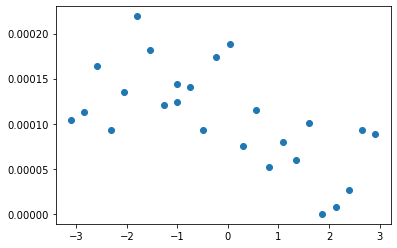

{-1.0142589454650879: (0.00014411176380235702, nan),
 -0.7522589454650879: (0.0001404888607794419, nan),
 -0.49025894546508786: (9.277481876779348e-05, nan),
 -0.22825894546508785: (0.00017444109835196286, nan),
 0.03374105453491216: (0.00018802404520101845, nan),
 0.2957410545349122: (7.566227577626705e-05, nan),
 0.5577410545349122: (0.00011577203986234963, nan),
 0.8197410545349122: (5.256562144495547e-05, nan),
 1.0817410545349122: (7.954047759994864e-05, nan),
 1.3437410545349122: (5.924847209826112e-05, nan),
 1.6057410545349122: (0.00010080973152071238, nan),
 1.8677410545349122: (0.0, nan),
 2.1297410545349122: (7.452516001649201e-06, nan),
 2.3917410545349123: (2.7019064873456955e-05, nan),
 2.6537410545349123: (9.258431964553893e-05, nan),
 2.9157410545349123: (8.888044976629317e-05, nan),
 -3.105444252644674: (0.00010439226753078401, nan),
 -2.843444252644674: (0.00011273195559624583, nan),
 -2.581444252644674: (0.000164483513799496, nan),
 -2.319444252644674: (9.25921194721

In [20]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(htf_ta, 0, False, [669, 670, 14877, 14878], [669, 670, 673, 676], [14879, 14880])

3901.616098234671


100%|██████████| 10000/10000 [00:08<00:00, 1207.74it/s]
INFO:root:Rotating by 2.145332722606093 radians
INFO:root:Rotating by 0.26199999999999896 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.261999999999998 radians
INFO:root:Rotating by 0.26199999999999846 radians
INFO:root:Rotating by 0.26199999999999757 radians
INFO:root:Rotating by 0.2620000000000027 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by -6.021185307179585 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26199999999999757 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.261999999999998 radians
INFO:root

0.20081258
-78654.53055822961
-78654.53225284399
-78654.53244727987
-78654.53241945307
-78654.53236217391
-78654.53237805133
-78654.5323561582
-78654.53222347486
-78654.53230407587
-78654.53244870812
-78654.53216730616
-78654.53246296971
-78654.53214630808
-78654.53230888318
-78654.53214766878
-78654.5321488738
-78654.5321877671
-78654.53218276108
-78654.53219130107
-78654.53214886451
-78654.53224813822

INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000245 radians
INFO:root:Rotating by 0.2619999999999994 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26199999999999957 radians



-78654.53239700016
-78654.53220554692
-78654.53220147015
-78654.53243138667
raw d: {0.46281257820129396: (-78654.53225284399, nan), 0.724812578201294: (-78654.53244727987, nan), 0.986812578201294: (-78654.53241945307, nan), 1.248812578201294: (-78654.53236217391, nan), 1.510812578201294: (-78654.53237805133, nan), 1.772812578201294: (-78654.5323561582, nan), 2.034812578201294: (-78654.53222347486, nan), 2.296812578201294: (-78654.53230407587, nan), 2.558812578201294: (-78654.53244870812, nan), 2.820812578201294: (-78654.53216730616, nan), 3.082812578201294: (-78654.53246296971, nan), -2.938372728978292: (-78654.53214630808, nan), -2.676372728978292: (-78654.53230888318, nan), -2.414372728978292: (-78654.53214766878, nan), -2.152372728978292: (-78654.5321488738, nan), -1.8903727289782921: (-78654.5321877671, nan), -1.628372728978292: (-78654.53218276108, nan), -1.366372728978292: (-78654.53219130107, nan), -1.104372728978292: (-78654.53214886451, nan), -0.8423727289782921: (-78654.5322

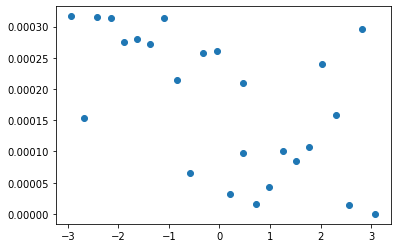

{0.46281257820129396: (0.00021012572688050568, nan),
 0.724812578201294: (1.5689845895394683e-05, nan),
 0.986812578201294: (4.35166439274326e-05, nan),
 1.248812578201294: (0.00010079580533783883, nan),
 1.510812578201294: (8.49183852551505e-05, nan),
 1.772812578201294: (0.00010681150888558477, nan),
 2.034812578201294: (0.00023949485330376774, nan),
 2.296812578201294: (0.00015889384667389095, nan),
 2.558812578201294: (1.4261589967645705e-05, nan),
 2.820812578201294: (0.0002956635580630973, nan),
 3.082812578201294: (0.0, nan),
 -2.938372728978292: (0.0003166616370435804, nan),
 -2.676372728978292: (0.0001540865341667086, nan),
 -2.414372728978292: (0.0003153009311063215, nan),
 -2.152372728978292: (0.0003140959161100909, nan),
 -1.8903727289782921: (0.00027520261937752366, nan),
 -1.628372728978292: (0.00028020863828714937, nan),
 -1.366372728978292: (0.0002716686431085691, nan),
 -1.104372728978292: (0.0003141052002320066, nan),
 -0.8423727289782921: (0.0002148314961232245, nan)

In [21]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(htf_ta, 1, False,  [669, 670, 673, 674], [669, 670, 673, 674], [675, 678, 679, 680, 681, 682])


### Generate torsion scans for the complex htf with flattened torsions and exceptions: T42A

In [5]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/11/" # 10 ns eq, 2 ns neq
with open(os.path.join(outdir, "11_complex.pickle" ), "rb") as f:
    htf_ta = pickle.load(f)

#### Look at hybrid and vanilla topologies to determine indices

In [6]:
for atom in htf_ta.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
LYS1-N 6
LYS1-CA 7
LYS1-C 8
LYS1-O 9
LYS1-CB 10
LYS1-CG 11
LYS1-CD 12
LYS1-CE 13
LYS1-NZ 14
LYS1-H2 15
LYS1-HA 16
LYS1-HB3 17
LYS1-HB2 18
LYS1-HG2 19
LYS1-HG3 20
LYS1-HD2 21
LYS1-HD3 22
LYS1-HE3 23
LYS1-HE2 24
LYS1-HZ1 25
LYS1-HZ2 26
LYS1-HZ3 27
LYS2-N 28
LYS2-CA 29
LYS2-C 30
LYS2-O 31
LYS2-CB 32
LYS2-CG 33
LYS2-CD 34
LYS2-CE 35
LYS2-NZ 36
LYS2-H 37
LYS2-HA 38
LYS2-HB3 39
LYS2-HB2 40
LYS2-HG2 41
LYS2-HG3 42
LYS2-HD3 43
LYS2-HD2 44
LYS2-HE3 45
LYS2-HE2 46
LYS2-HZ1 47
LYS2-HZ2 48
LYS2-HZ3 49
ALA3-N 50
ALA3-CA 51
ALA3-C 52
ALA3-O 53
ALA3-CB 54
ALA3-H 55
ALA3-HA 56
ALA3-HB1 57
ALA3-HB2 58
ALA3-HB3 59
VAL4-N 60
VAL4-CA 61
VAL4-C 62
VAL4-O 63
VAL4-CB 64
VAL4-CG1 65
VAL4-CG2 66
VAL4-H 67
VAL4-HA 68
VAL4-HB 69
VAL4-HG11 70
VAL4-HG12 71
VAL4-HG13 72
VAL4-HG21 73
VAL4-HG22 74
VAL4-HG23 75
ILE5-N 76
ILE5-CA 77
ILE5-C 78
ILE5-O 79
ILE5-CB 80
ILE5-CG1 81
ILE5-CG2 82
ILE5-CD1 83
ILE5-H 84
ILE5-HA 85
ILE5-HB 86
ILE5-HG13 87
ILE5-HG12 88
ILE5-

ARG75-CG 1214
ARG75-CD 1215
ARG75-NE 1216
ARG75-CZ 1217
ARG75-NH1 1218
ARG75-NH2 1219
ARG75-H 1220
ARG75-HA 1221
ARG75-HB3 1222
ARG75-HB2 1223
ARG75-HG3 1224
ARG75-HG2 1225
ARG75-HD3 1226
ARG75-HD2 1227
ARG75-HE 1228
ARG75-HH11 1229
ARG75-HH12 1230
ARG75-HH21 1231
ARG75-HH22 1232
GLU76-N 1233
GLU76-CA 1234
GLU76-C 1235
GLU76-O 1236
GLU76-CB 1237
GLU76-CG 1238
GLU76-CD 1239
GLU76-OE1 1240
GLU76-OE2 1241
GLU76-H 1242
GLU76-HA 1243
GLU76-HB3 1244
GLU76-HB2 1245
GLU76-HG3 1246
GLU76-HG2 1247
ALA77-N 1248
ALA77-CA 1249
ALA77-C 1250
ALA77-O 1251
ALA77-CB 1252
ALA77-H 1253
ALA77-HA 1254
ALA77-HB1 1255
ALA77-HB2 1256
ALA77-HB3 1257
LYS78-N 1258
LYS78-CA 1259
LYS78-C 1260
LYS78-O 1261
LYS78-CB 1262
LYS78-CG 1263
LYS78-CD 1264
LYS78-CE 1265
LYS78-NZ 1266
LYS78-H 1267
LYS78-HA 1268
LYS78-HB3 1269
LYS78-HB2 1270
LYS78-HG3 1271
LYS78-HG2 1272
LYS78-HD3 1273
LYS78-HD2 1274
LYS78-HE2 1275
LYS78-HE3 1276
LYS78-HZ1 1277
LYS78-HZ2 1278
LYS78-HZ3 1279
ALA79-N 1280
ALA79-CA 1281
ALA79-C 1282
ALA79-O 1283


THR70-HG22 2463
THR70-HG23 2464
TRP71-N 2465
TRP71-CA 2466
TRP71-C 2467
TRP71-O 2468
TRP71-CB 2469
TRP71-CG 2470
TRP71-CD1 2471
TRP71-CD2 2472
TRP71-NE1 2473
TRP71-CE2 2474
TRP71-CE3 2475
TRP71-CZ2 2476
TRP71-CZ3 2477
TRP71-CH2 2478
TRP71-H 2479
TRP71-HA 2480
TRP71-HB3 2481
TRP71-HB2 2482
TRP71-HD1 2483
TRP71-HE1 2484
TRP71-HE3 2485
TRP71-HZ2 2486
TRP71-HZ3 2487
TRP71-HH2 2488
ARG72-N 2489
ARG72-CA 2490
ARG72-C 2491
ARG72-O 2492
ARG72-CB 2493
ARG72-CG 2494
ARG72-CD 2495
ARG72-NE 2496
ARG72-CZ 2497
ARG72-NH1 2498
ARG72-NH2 2499
ARG72-H 2500
ARG72-HA 2501
ARG72-HB3 2502
ARG72-HB2 2503
ARG72-HG3 2504
ARG72-HG2 2505
ARG72-HD3 2506
ARG72-HD2 2507
ARG72-HE 2508
ARG72-HH11 2509
ARG72-HH12 2510
ARG72-HH21 2511
ARG72-HH22 2512
GLU73-N 2513
GLU73-CA 2514
GLU73-C 2515
GLU73-O 2516
GLU73-CB 2517
GLU73-CG 2518
GLU73-CD 2519
GLU73-OE1 2520
GLU73-OE2 2521
GLU73-H 2522
GLU73-HA 2523
GLU73-HB2 2524
GLU73-HB3 2525
GLU73-HG2 2526
GLU73-HG3 2527
ALA74-N 2528
ALA74-CA 2529
ALA74-C 2530
ALA74-O 2531
ALA74-C

HOH389-H2 3713
HOH390-O 3714
HOH390-H1 3715
HOH390-H2 3716
HOH391-O 3717
HOH391-H1 3718
HOH391-H2 3719
HOH392-O 3720
HOH392-H1 3721
HOH392-H2 3722
HOH393-O 3723
HOH393-H1 3724
HOH393-H2 3725
HOH394-O 3726
HOH394-H1 3727
HOH394-H2 3728
HOH395-O 3729
HOH395-H1 3730
HOH395-H2 3731
HOH396-O 3732
HOH396-H1 3733
HOH396-H2 3734
HOH397-O 3735
HOH397-H1 3736
HOH397-H2 3737
HOH398-O 3738
HOH398-H1 3739
HOH398-H2 3740
HOH399-O 3741
HOH399-H1 3742
HOH399-H2 3743
HOH400-O 3744
HOH400-H1 3745
HOH400-H2 3746
HOH401-O 3747
HOH401-H1 3748
HOH401-H2 3749
HOH402-O 3750
HOH402-H1 3751
HOH402-H2 3752
HOH403-O 3753
HOH403-H1 3754
HOH403-H2 3755
HOH404-O 3756
HOH404-H1 3757
HOH404-H2 3758
HOH405-O 3759
HOH405-H1 3760
HOH405-H2 3761
HOH406-O 3762
HOH406-H1 3763
HOH406-H2 3764
HOH407-O 3765
HOH407-H1 3766
HOH407-H2 3767
HOH408-O 3768
HOH408-H1 3769
HOH408-H2 3770
HOH409-O 3771
HOH409-H1 3772
HOH409-H2 3773
HOH410-O 3774
HOH410-H1 3775
HOH410-H2 3776
HOH411-O 3777
HOH411-H1 3778
HOH411-H2 3779
HOH412-O 3780
HOH

HOH806-H1 4963
HOH806-H2 4964
HOH807-O 4965
HOH807-H1 4966
HOH807-H2 4967
HOH808-O 4968
HOH808-H1 4969
HOH808-H2 4970
HOH809-O 4971
HOH809-H1 4972
HOH809-H2 4973
HOH810-O 4974
HOH810-H1 4975
HOH810-H2 4976
HOH811-O 4977
HOH811-H1 4978
HOH811-H2 4979
HOH812-O 4980
HOH812-H1 4981
HOH812-H2 4982
HOH813-O 4983
HOH813-H1 4984
HOH813-H2 4985
HOH814-O 4986
HOH814-H1 4987
HOH814-H2 4988
HOH815-O 4989
HOH815-H1 4990
HOH815-H2 4991
HOH816-O 4992
HOH816-H1 4993
HOH816-H2 4994
HOH817-O 4995
HOH817-H1 4996
HOH817-H2 4997
HOH818-O 4998
HOH818-H1 4999
HOH818-H2 5000
HOH819-O 5001
HOH819-H1 5002
HOH819-H2 5003
HOH820-O 5004
HOH820-H1 5005
HOH820-H2 5006
HOH821-O 5007
HOH821-H1 5008
HOH821-H2 5009
HOH822-O 5010
HOH822-H1 5011
HOH822-H2 5012
HOH823-O 5013
HOH823-H1 5014
HOH823-H2 5015
HOH824-O 5016
HOH824-H1 5017
HOH824-H2 5018
HOH825-O 5019
HOH825-H1 5020
HOH825-H2 5021
HOH826-O 5022
HOH826-H1 5023
HOH826-H2 5024
HOH827-O 5025
HOH827-H1 5026
HOH827-H2 5027
HOH828-O 5028
HOH828-H1 5029
HOH828-H2 5030
HO

HOH1225-O 6213
HOH1225-H1 6214
HOH1225-H2 6215
HOH1226-O 6216
HOH1226-H1 6217
HOH1226-H2 6218
HOH1227-O 6219
HOH1227-H1 6220
HOH1227-H2 6221
HOH1228-O 6222
HOH1228-H1 6223
HOH1228-H2 6224
HOH1229-O 6225
HOH1229-H1 6226
HOH1229-H2 6227
HOH1230-O 6228
HOH1230-H1 6229
HOH1230-H2 6230
HOH1231-O 6231
HOH1231-H1 6232
HOH1231-H2 6233
HOH1232-O 6234
HOH1232-H1 6235
HOH1232-H2 6236
HOH1233-O 6237
HOH1233-H1 6238
HOH1233-H2 6239
HOH1234-O 6240
HOH1234-H1 6241
HOH1234-H2 6242
HOH1235-O 6243
HOH1235-H1 6244
HOH1235-H2 6245
HOH1236-O 6246
HOH1236-H1 6247
HOH1236-H2 6248
HOH1237-O 6249
HOH1237-H1 6250
HOH1237-H2 6251
HOH1238-O 6252
HOH1238-H1 6253
HOH1238-H2 6254
HOH1239-O 6255
HOH1239-H1 6256
HOH1239-H2 6257
HOH1240-O 6258
HOH1240-H1 6259
HOH1240-H2 6260
HOH1241-O 6261
HOH1241-H1 6262
HOH1241-H2 6263
HOH1242-O 6264
HOH1242-H1 6265
HOH1242-H2 6266
HOH1243-O 6267
HOH1243-H1 6268
HOH1243-H2 6269
HOH1244-O 6270
HOH1244-H1 6271
HOH1244-H2 6272
HOH1245-O 6273
HOH1245-H1 6274
HOH1245-H2 6275
HOH1246-O 627

HOH1641-H1 7462
HOH1641-H2 7463
HOH1642-O 7464
HOH1642-H1 7465
HOH1642-H2 7466
HOH1643-O 7467
HOH1643-H1 7468
HOH1643-H2 7469
HOH1644-O 7470
HOH1644-H1 7471
HOH1644-H2 7472
HOH1645-O 7473
HOH1645-H1 7474
HOH1645-H2 7475
HOH1646-O 7476
HOH1646-H1 7477
HOH1646-H2 7478
HOH1647-O 7479
HOH1647-H1 7480
HOH1647-H2 7481
HOH1648-O 7482
HOH1648-H1 7483
HOH1648-H2 7484
HOH1649-O 7485
HOH1649-H1 7486
HOH1649-H2 7487
HOH1650-O 7488
HOH1650-H1 7489
HOH1650-H2 7490
HOH1651-O 7491
HOH1651-H1 7492
HOH1651-H2 7493
HOH1652-O 7494
HOH1652-H1 7495
HOH1652-H2 7496
HOH1653-O 7497
HOH1653-H1 7498
HOH1653-H2 7499
HOH1654-O 7500
HOH1654-H1 7501
HOH1654-H2 7502
HOH1655-O 7503
HOH1655-H1 7504
HOH1655-H2 7505
HOH1656-O 7506
HOH1656-H1 7507
HOH1656-H2 7508
HOH1657-O 7509
HOH1657-H1 7510
HOH1657-H2 7511
HOH1658-O 7512
HOH1658-H1 7513
HOH1658-H2 7514
HOH1659-O 7515
HOH1659-H1 7516
HOH1659-H2 7517
HOH1660-O 7518
HOH1660-H1 7519
HOH1660-H2 7520
HOH1661-O 7521
HOH1661-H1 7522
HOH1661-H2 7523
HOH1662-O 7524
HOH1662-H1 75

HOH2060-O 8712
HOH2060-H1 8713
HOH2060-H2 8714
HOH2061-O 8715
HOH2061-H1 8716
HOH2061-H2 8717
HOH2062-O 8718
HOH2062-H1 8719
HOH2062-H2 8720
HOH2063-O 8721
HOH2063-H1 8722
HOH2063-H2 8723
HOH2064-O 8724
HOH2064-H1 8725
HOH2064-H2 8726
HOH2065-O 8727
HOH2065-H1 8728
HOH2065-H2 8729
HOH2066-O 8730
HOH2066-H1 8731
HOH2066-H2 8732
HOH2067-O 8733
HOH2067-H1 8734
HOH2067-H2 8735
HOH2068-O 8736
HOH2068-H1 8737
HOH2068-H2 8738
HOH2069-O 8739
HOH2069-H1 8740
HOH2069-H2 8741
HOH2070-O 8742
HOH2070-H1 8743
HOH2070-H2 8744
HOH2071-O 8745
HOH2071-H1 8746
HOH2071-H2 8747
HOH2072-O 8748
HOH2072-H1 8749
HOH2072-H2 8750
HOH2073-O 8751
HOH2073-H1 8752
HOH2073-H2 8753
HOH2074-O 8754
HOH2074-H1 8755
HOH2074-H2 8756
HOH2075-O 8757
HOH2075-H1 8758
HOH2075-H2 8759
HOH2076-O 8760
HOH2076-H1 8761
HOH2076-H2 8762
HOH2077-O 8763
HOH2077-H1 8764
HOH2077-H2 8765
HOH2078-O 8766
HOH2078-H1 8767
HOH2078-H2 8768
HOH2079-O 8769
HOH2079-H1 8770
HOH2079-H2 8771
HOH2080-O 8772
HOH2080-H1 8773
HOH2080-H2 8774
HOH2081-O 877

HOH2560-O 10212
HOH2560-H1 10213
HOH2560-H2 10214
HOH2561-O 10215
HOH2561-H1 10216
HOH2561-H2 10217
HOH2562-O 10218
HOH2562-H1 10219
HOH2562-H2 10220
HOH2563-O 10221
HOH2563-H1 10222
HOH2563-H2 10223
HOH2564-O 10224
HOH2564-H1 10225
HOH2564-H2 10226
HOH2565-O 10227
HOH2565-H1 10228
HOH2565-H2 10229
HOH2566-O 10230
HOH2566-H1 10231
HOH2566-H2 10232
HOH2567-O 10233
HOH2567-H1 10234
HOH2567-H2 10235
HOH2568-O 10236
HOH2568-H1 10237
HOH2568-H2 10238
HOH2569-O 10239
HOH2569-H1 10240
HOH2569-H2 10241
HOH2570-O 10242
HOH2570-H1 10243
HOH2570-H2 10244
HOH2571-O 10245
HOH2571-H1 10246
HOH2571-H2 10247
HOH2572-O 10248
HOH2572-H1 10249
HOH2572-H2 10250
HOH2573-O 10251
HOH2573-H1 10252
HOH2573-H2 10253
HOH2574-O 10254
HOH2574-H1 10255
HOH2574-H2 10256
HOH2575-O 10257
HOH2575-H1 10258
HOH2575-H2 10259
HOH2576-O 10260
HOH2576-H1 10261
HOH2576-H2 10262
HOH2577-O 10263
HOH2577-H1 10264
HOH2577-H2 10265
HOH2578-O 10266
HOH2578-H1 10267
HOH2578-H2 10268
HOH2579-O 10269
HOH2579-H1 10270
HOH2579-H2 10271


HOH3060-O 11712
HOH3060-H1 11713
HOH3060-H2 11714
HOH3061-O 11715
HOH3061-H1 11716
HOH3061-H2 11717
HOH3062-O 11718
HOH3062-H1 11719
HOH3062-H2 11720
HOH3063-O 11721
HOH3063-H1 11722
HOH3063-H2 11723
HOH3064-O 11724
HOH3064-H1 11725
HOH3064-H2 11726
HOH3065-O 11727
HOH3065-H1 11728
HOH3065-H2 11729
HOH3066-O 11730
HOH3066-H1 11731
HOH3066-H2 11732
HOH3067-O 11733
HOH3067-H1 11734
HOH3067-H2 11735
HOH3068-O 11736
HOH3068-H1 11737
HOH3068-H2 11738
HOH3069-O 11739
HOH3069-H1 11740
HOH3069-H2 11741
HOH3070-O 11742
HOH3070-H1 11743
HOH3070-H2 11744
HOH3071-O 11745
HOH3071-H1 11746
HOH3071-H2 11747
HOH3072-O 11748
HOH3072-H1 11749
HOH3072-H2 11750
HOH3073-O 11751
HOH3073-H1 11752
HOH3073-H2 11753
HOH3074-O 11754
HOH3074-H1 11755
HOH3074-H2 11756
HOH3075-O 11757
HOH3075-H1 11758
HOH3075-H2 11759
HOH3076-O 11760
HOH3076-H1 11761
HOH3076-H2 11762
HOH3077-O 11763
HOH3077-H1 11764
HOH3077-H2 11765
HOH3078-O 11766
HOH3078-H1 11767
HOH3078-H2 11768
HOH3079-O 11769
HOH3079-H1 11770
HOH3079-H2 11771


HOH3476-H1 12961
HOH3476-H2 12962
HOH3477-O 12963
HOH3477-H1 12964
HOH3477-H2 12965
HOH3478-O 12966
HOH3478-H1 12967
HOH3478-H2 12968
HOH3479-O 12969
HOH3479-H1 12970
HOH3479-H2 12971
HOH3480-O 12972
HOH3480-H1 12973
HOH3480-H2 12974
HOH3481-O 12975
HOH3481-H1 12976
HOH3481-H2 12977
HOH3482-O 12978
HOH3482-H1 12979
HOH3482-H2 12980
HOH3483-O 12981
HOH3483-H1 12982
HOH3483-H2 12983
HOH3484-O 12984
HOH3484-H1 12985
HOH3484-H2 12986
HOH3485-O 12987
HOH3485-H1 12988
HOH3485-H2 12989
HOH3486-O 12990
HOH3486-H1 12991
HOH3486-H2 12992
HOH3487-O 12993
HOH3487-H1 12994
HOH3487-H2 12995
HOH3488-O 12996
HOH3488-H1 12997
HOH3488-H2 12998
HOH3489-O 12999
HOH3489-H1 13000
HOH3489-H2 13001
HOH3490-O 13002
HOH3490-H1 13003
HOH3490-H2 13004
HOH3491-O 13005
HOH3491-H1 13006
HOH3491-H2 13007
HOH3492-O 13008
HOH3492-H1 13009
HOH3492-H2 13010
HOH3493-O 13011
HOH3493-H1 13012
HOH3493-H2 13013
HOH3494-O 13014
HOH3494-H1 13015
HOH3494-H2 13016
HOH3495-O 13017
HOH3495-H1 13018
HOH3495-H2 13019
HOH3496-O 13020


HOH3893-O 14211
HOH3893-H1 14212
HOH3893-H2 14213
HOH3894-O 14214
HOH3894-H1 14215
HOH3894-H2 14216
HOH3895-O 14217
HOH3895-H1 14218
HOH3895-H2 14219
HOH3896-O 14220
HOH3896-H1 14221
HOH3896-H2 14222
HOH3897-O 14223
HOH3897-H1 14224
HOH3897-H2 14225
HOH3898-O 14226
HOH3898-H1 14227
HOH3898-H2 14228
HOH3899-O 14229
HOH3899-H1 14230
HOH3899-H2 14231
HOH3900-O 14232
HOH3900-H1 14233
HOH3900-H2 14234
HOH3901-O 14235
HOH3901-H1 14236
HOH3901-H2 14237
HOH3902-O 14238
HOH3902-H1 14239
HOH3902-H2 14240
HOH3903-O 14241
HOH3903-H1 14242
HOH3903-H2 14243
HOH3904-O 14244
HOH3904-H1 14245
HOH3904-H2 14246
HOH3905-O 14247
HOH3905-H1 14248
HOH3905-H2 14249
HOH3906-O 14250
HOH3906-H1 14251
HOH3906-H2 14252
HOH3907-O 14253
HOH3907-H1 14254
HOH3907-H2 14255
HOH3908-O 14256
HOH3908-H1 14257
HOH3908-H2 14258
HOH3909-O 14259
HOH3909-H1 14260
HOH3909-H2 14261
HOH3910-O 14262
HOH3910-H1 14263
HOH3910-H2 14264
HOH3911-O 14265
HOH3911-H1 14266
HOH3911-H2 14267
HOH3912-O 14268
HOH3912-H1 14269
HOH3912-H2 14270


HOH4397-O 15711
HOH4397-H1 15712
HOH4397-H2 15713
HOH4398-O 15714
HOH4398-H1 15715
HOH4398-H2 15716
HOH4399-O 15717
HOH4399-H1 15718
HOH4399-H2 15719
HOH4400-O 15720
HOH4400-H1 15721
HOH4400-H2 15722
HOH4401-O 15723
HOH4401-H1 15724
HOH4401-H2 15725
HOH4402-O 15726
HOH4402-H1 15727
HOH4402-H2 15728
HOH4403-O 15729
HOH4403-H1 15730
HOH4403-H2 15731
HOH4404-O 15732
HOH4404-H1 15733
HOH4404-H2 15734
HOH4405-O 15735
HOH4405-H1 15736
HOH4405-H2 15737
HOH4406-O 15738
HOH4406-H1 15739
HOH4406-H2 15740
HOH4407-O 15741
HOH4407-H1 15742
HOH4407-H2 15743
HOH4408-O 15744
HOH4408-H1 15745
HOH4408-H2 15746
HOH4409-O 15747
HOH4409-H1 15748
HOH4409-H2 15749
HOH4410-O 15750
HOH4410-H1 15751
HOH4410-H2 15752
HOH4411-O 15753
HOH4411-H1 15754
HOH4411-H2 15755
HOH4412-O 15756
HOH4412-H1 15757
HOH4412-H2 15758
HOH4413-O 15759
HOH4413-H1 15760
HOH4413-H2 15761
HOH4414-O 15762
HOH4414-H1 15763
HOH4414-H2 15764
HOH4415-O 15765
HOH4415-H1 15766
HOH4415-H2 15767
HOH4416-O 15768
HOH4416-H1 15769
HOH4416-H2 15770


HOH4897-O 17211
HOH4897-H1 17212
HOH4897-H2 17213
HOH4898-O 17214
HOH4898-H1 17215
HOH4898-H2 17216
HOH4899-O 17217
HOH4899-H1 17218
HOH4899-H2 17219
HOH4900-O 17220
HOH4900-H1 17221
HOH4900-H2 17222
HOH4901-O 17223
HOH4901-H1 17224
HOH4901-H2 17225
HOH4902-O 17226
HOH4902-H1 17227
HOH4902-H2 17228
HOH4903-O 17229
HOH4903-H1 17230
HOH4903-H2 17231
HOH4904-O 17232
HOH4904-H1 17233
HOH4904-H2 17234
HOH4905-O 17235
HOH4905-H1 17236
HOH4905-H2 17237
HOH4906-O 17238
HOH4906-H1 17239
HOH4906-H2 17240
HOH4907-O 17241
HOH4907-H1 17242
HOH4907-H2 17243
HOH4908-O 17244
HOH4908-H1 17245
HOH4908-H2 17246
HOH4909-O 17247
HOH4909-H1 17248
HOH4909-H2 17249
HOH4910-O 17250
HOH4910-H1 17251
HOH4910-H2 17252
HOH4911-O 17253
HOH4911-H1 17254
HOH4911-H2 17255
HOH4912-O 17256
HOH4912-H1 17257
HOH4912-H2 17258
HOH4913-O 17259
HOH4913-H1 17260
HOH4913-H2 17261
HOH4914-O 17262
HOH4914-H1 17263
HOH4914-H2 17264
HOH4915-O 17265
HOH4915-H1 17266
HOH4915-H2 17267
HOH4916-O 17268
HOH4916-H1 17269
HOH4916-H2 17270


HOH5398-H2 18710
HOH5399-O 18711
HOH5399-H1 18712
HOH5399-H2 18713
HOH5400-O 18714
HOH5400-H1 18715
HOH5400-H2 18716
HOH5401-O 18717
HOH5401-H1 18718
HOH5401-H2 18719
HOH5402-O 18720
HOH5402-H1 18721
HOH5402-H2 18722
HOH5403-O 18723
HOH5403-H1 18724
HOH5403-H2 18725
HOH5404-O 18726
HOH5404-H1 18727
HOH5404-H2 18728
HOH5405-O 18729
HOH5405-H1 18730
HOH5405-H2 18731
HOH5406-O 18732
HOH5406-H1 18733
HOH5406-H2 18734
HOH5407-O 18735
HOH5407-H1 18736
HOH5407-H2 18737
HOH5408-O 18738
HOH5408-H1 18739
HOH5408-H2 18740
HOH5409-O 18741
HOH5409-H1 18742
HOH5409-H2 18743
HOH5410-O 18744
HOH5410-H1 18745
HOH5410-H2 18746
HOH5411-O 18747
HOH5411-H1 18748
HOH5411-H2 18749
HOH5412-O 18750
HOH5412-H1 18751
HOH5412-H2 18752
HOH5413-O 18753
HOH5413-H1 18754
HOH5413-H2 18755
HOH5414-O 18756
HOH5414-H1 18757
HOH5414-H2 18758
HOH5415-O 18759
HOH5415-H1 18760
HOH5415-H2 18761
HOH5416-O 18762
HOH5416-H1 18763
HOH5416-H2 18764
HOH5417-O 18765
HOH5417-H1 18766
HOH5417-H2 18767
HOH5418-O 18768
HOH5418-H1 18769


HOH5898-H2 20210
HOH5899-O 20211
HOH5899-H1 20212
HOH5899-H2 20213
HOH5900-O 20214
HOH5900-H1 20215
HOH5900-H2 20216
HOH5901-O 20217
HOH5901-H1 20218
HOH5901-H2 20219
HOH5902-O 20220
HOH5902-H1 20221
HOH5902-H2 20222
HOH5903-O 20223
HOH5903-H1 20224
HOH5903-H2 20225
HOH5904-O 20226
HOH5904-H1 20227
HOH5904-H2 20228
HOH5905-O 20229
HOH5905-H1 20230
HOH5905-H2 20231
HOH5906-O 20232
HOH5906-H1 20233
HOH5906-H2 20234
HOH5907-O 20235
HOH5907-H1 20236
HOH5907-H2 20237
HOH5908-O 20238
HOH5908-H1 20239
HOH5908-H2 20240
HOH5909-O 20241
HOH5909-H1 20242
HOH5909-H2 20243
HOH5910-O 20244
HOH5910-H1 20245
HOH5910-H2 20246
HOH5911-O 20247
HOH5911-H1 20248
HOH5911-H2 20249
HOH5912-O 20250
HOH5912-H1 20251
HOH5912-H2 20252
HOH5913-O 20253
HOH5913-H1 20254
HOH5913-H2 20255
HOH5914-O 20256
HOH5914-H1 20257
HOH5914-H2 20258
HOH5915-O 20259
HOH5915-H1 20260
HOH5915-H2 20261
HOH5916-O 20262
HOH5916-H1 20263
HOH5916-H2 20264
HOH5917-O 20265
HOH5917-H1 20266
HOH5917-H2 20267
HOH5918-O 20268
HOH5918-H1 20269


HOH6400-H2 21710
HOH6401-O 21711
HOH6401-H1 21712
HOH6401-H2 21713
HOH6402-O 21714
HOH6402-H1 21715
HOH6402-H2 21716
HOH6403-O 21717
HOH6403-H1 21718
HOH6403-H2 21719
HOH6404-O 21720
HOH6404-H1 21721
HOH6404-H2 21722
HOH6405-O 21723
HOH6405-H1 21724
HOH6405-H2 21725
HOH6406-O 21726
HOH6406-H1 21727
HOH6406-H2 21728
HOH6407-O 21729
HOH6407-H1 21730
HOH6407-H2 21731
HOH6408-O 21732
HOH6408-H1 21733
HOH6408-H2 21734
HOH6409-O 21735
HOH6409-H1 21736
HOH6409-H2 21737
HOH6410-O 21738
HOH6410-H1 21739
HOH6410-H2 21740
HOH6411-O 21741
HOH6411-H1 21742
HOH6411-H2 21743
HOH6412-O 21744
HOH6412-H1 21745
HOH6412-H2 21746
HOH6413-O 21747
HOH6413-H1 21748
HOH6413-H2 21749
HOH6414-O 21750
HOH6414-H1 21751
HOH6414-H2 21752
HOH6415-O 21753
HOH6415-H1 21754
HOH6415-H2 21755
HOH6416-O 21756
HOH6416-H1 21757
HOH6416-H2 21758
HOH6417-O 21759
HOH6417-H1 21760
HOH6417-H2 21761
HOH6418-O 21762
HOH6418-H1 21763
HOH6418-H2 21764
HOH6419-O 21765
HOH6419-H1 21766
HOH6419-H2 21767
HOH6420-O 21768
HOH6420-H1 21769


HOH6818-H1 22960
HOH6818-H2 22961
HOH6819-O 22962
HOH6819-H1 22963
HOH6819-H2 22964
HOH6820-O 22965
HOH6820-H1 22966
HOH6820-H2 22967
HOH6821-O 22968
HOH6821-H1 22969
HOH6821-H2 22970
HOH6822-O 22971
HOH6822-H1 22972
HOH6822-H2 22973
HOH6823-O 22974
HOH6823-H1 22975
HOH6823-H2 22976
HOH6824-O 22977
HOH6824-H1 22978
HOH6824-H2 22979
HOH6825-O 22980
HOH6825-H1 22981
HOH6825-H2 22982
HOH6827-O 22983
HOH6827-H1 22984
HOH6827-H2 22985
HOH6828-O 22986
HOH6828-H1 22987
HOH6828-H2 22988
HOH6829-O 22989
HOH6829-H1 22990
HOH6829-H2 22991
HOH6830-O 22992
HOH6830-H1 22993
HOH6830-H2 22994
HOH6831-O 22995
HOH6831-H1 22996
HOH6831-H2 22997
HOH6832-O 22998
HOH6832-H1 22999
HOH6832-H2 23000
HOH6833-O 23001
HOH6833-H1 23002
HOH6833-H2 23003
HOH6834-O 23004
HOH6834-H1 23005
HOH6834-H2 23006
HOH6835-O 23007
HOH6835-H1 23008
HOH6835-H2 23009
HOH6836-O 23010
HOH6836-H1 23011
HOH6836-H2 23012
HOH6837-O 23013
HOH6837-H1 23014
HOH6837-H2 23015
HOH6838-O 23016
HOH6838-H1 23017
HOH6838-H2 23018
HOH6839-O 23019


HOH7237-H2 24209
HOH7238-O 24210
HOH7238-H1 24211
HOH7238-H2 24212
HOH7239-O 24213
HOH7239-H1 24214
HOH7239-H2 24215
HOH7240-O 24216
HOH7240-H1 24217
HOH7240-H2 24218
HOH7241-O 24219
HOH7241-H1 24220
HOH7241-H2 24221
HOH7242-O 24222
HOH7242-H1 24223
HOH7242-H2 24224
HOH7243-O 24225
HOH7243-H1 24226
HOH7243-H2 24227
HOH7244-O 24228
HOH7244-H1 24229
HOH7244-H2 24230
HOH7245-O 24231
HOH7245-H1 24232
HOH7245-H2 24233
HOH7246-O 24234
HOH7246-H1 24235
HOH7246-H2 24236
HOH7247-O 24237
HOH7247-H1 24238
HOH7247-H2 24239
HOH7248-O 24240
HOH7248-H1 24241
HOH7248-H2 24242
HOH7249-O 24243
HOH7249-H1 24244
HOH7249-H2 24245
HOH7250-O 24246
HOH7250-H1 24247
HOH7250-H2 24248
HOH7251-O 24249
HOH7251-H1 24250
HOH7251-H2 24251
HOH7252-O 24252
HOH7252-H1 24253
HOH7252-H2 24254
HOH7253-O 24255
HOH7253-H1 24256
HOH7253-H2 24257
HOH7254-O 24258
HOH7254-H1 24259
HOH7254-H2 24260
HOH7255-O 24261
HOH7255-H1 24262
HOH7255-H2 24263
HOH7256-O 24264
HOH7256-H1 24265
HOH7256-H2 24266
HOH7257-O 24267
HOH7257-H1 24268


HOH7655-H1 25459
HOH7655-H2 25460
HOH7656-O 25461
HOH7656-H1 25462
HOH7656-H2 25463
HOH7657-O 25464
HOH7657-H1 25465
HOH7657-H2 25466
HOH7658-O 25467
HOH7658-H1 25468
HOH7658-H2 25469
HOH7659-O 25470
HOH7659-H1 25471
HOH7659-H2 25472
HOH7660-O 25473
HOH7660-H1 25474
HOH7660-H2 25475
HOH7661-O 25476
HOH7661-H1 25477
HOH7661-H2 25478
HOH7662-O 25479
HOH7662-H1 25480
HOH7662-H2 25481
HOH7663-O 25482
HOH7663-H1 25483
HOH7663-H2 25484
HOH7664-O 25485
HOH7664-H1 25486
HOH7664-H2 25487
HOH7665-O 25488
HOH7665-H1 25489
HOH7665-H2 25490
HOH7666-O 25491
HOH7666-H1 25492
HOH7666-H2 25493
HOH7667-O 25494
HOH7667-H1 25495
HOH7667-H2 25496
HOH7668-O 25497
HOH7668-H1 25498
HOH7668-H2 25499
HOH7669-O 25500
HOH7669-H1 25501
HOH7669-H2 25502
HOH7670-O 25503
HOH7670-H1 25504
HOH7670-H2 25505
HOH7671-O 25506
HOH7671-H1 25507
HOH7671-H2 25508
HOH7672-O 25509
HOH7672-H1 25510
HOH7672-H2 25511
HOH7673-O 25512
HOH7673-H1 25513
HOH7673-H2 25514
HOH7674-O 25515
HOH7674-H1 25516
HOH7674-H2 25517
HOH7675-O 25518


HOH8072-O 26709
HOH8072-H1 26710
HOH8072-H2 26711
HOH8073-O 26712
HOH8073-H1 26713
HOH8073-H2 26714
HOH8074-O 26715
HOH8074-H1 26716
HOH8074-H2 26717
HOH8075-O 26718
HOH8075-H1 26719
HOH8075-H2 26720
HOH8076-O 26721
HOH8076-H1 26722
HOH8076-H2 26723
HOH8077-O 26724
HOH8077-H1 26725
HOH8077-H2 26726
HOH8078-O 26727
HOH8078-H1 26728
HOH8078-H2 26729
HOH8079-O 26730
HOH8079-H1 26731
HOH8079-H2 26732
HOH8080-O 26733
HOH8080-H1 26734
HOH8080-H2 26735
HOH8081-O 26736
HOH8081-H1 26737
HOH8081-H2 26738
HOH8082-O 26739
HOH8082-H1 26740
HOH8082-H2 26741
HOH8083-O 26742
HOH8083-H1 26743
HOH8083-H2 26744
HOH8084-O 26745
HOH8084-H1 26746
HOH8084-H2 26747
HOH8085-O 26748
HOH8085-H1 26749
HOH8085-H2 26750
HOH8086-O 26751
HOH8086-H1 26752
HOH8086-H2 26753
HOH8087-O 26754
HOH8087-H1 26755
HOH8087-H2 26756
HOH8088-O 26757
HOH8088-H1 26758
HOH8088-H2 26759
HOH8089-O 26760
HOH8089-H1 26761
HOH8089-H2 26762
HOH8090-O 26763
HOH8090-H1 26764
HOH8090-H2 26765
HOH8091-O 26766
HOH8091-H1 26767
HOH8091-H2 26768


HOH8491-H2 27959
HOH8492-O 27960
HOH8492-H1 27961
HOH8492-H2 27962
HOH8493-O 27963
HOH8493-H1 27964
HOH8493-H2 27965
HOH8494-O 27966
HOH8494-H1 27967
HOH8494-H2 27968
HOH8495-O 27969
HOH8495-H1 27970
HOH8495-H2 27971
HOH8496-O 27972
HOH8496-H1 27973
HOH8496-H2 27974
HOH8497-O 27975
HOH8497-H1 27976
HOH8497-H2 27977
HOH8498-O 27978
HOH8498-H1 27979
HOH8498-H2 27980
HOH8499-O 27981
HOH8499-H1 27982
HOH8499-H2 27983
HOH8500-O 27984
HOH8500-H1 27985
HOH8500-H2 27986
HOH8501-O 27987
HOH8501-H1 27988
HOH8501-H2 27989
HOH8502-O 27990
HOH8502-H1 27991
HOH8502-H2 27992
HOH8503-O 27993
HOH8503-H1 27994
HOH8503-H2 27995
HOH8504-O 27996
HOH8504-H1 27997
HOH8504-H2 27998
HOH8505-O 27999
HOH8505-H1 28000
HOH8505-H2 28001
HOH8506-O 28002
HOH8506-H1 28003
HOH8506-H2 28004
HOH8507-O 28005
HOH8507-H1 28006
HOH8507-H2 28007
HOH8508-O 28008
HOH8508-H1 28009
HOH8508-H2 28010
HOH8509-O 28011
HOH8509-H1 28012
HOH8509-H2 28013
HOH8510-O 28014
HOH8510-H1 28015
HOH8510-H2 28016
HOH8511-O 28017
HOH8511-H1 28018


HOH8908-O 29208
HOH8908-H1 29209
HOH8908-H2 29210
HOH8909-O 29211
HOH8909-H1 29212
HOH8909-H2 29213
HOH8910-O 29214
HOH8910-H1 29215
HOH8910-H2 29216
HOH8911-O 29217
HOH8911-H1 29218
HOH8911-H2 29219
HOH8912-O 29220
HOH8912-H1 29221
HOH8912-H2 29222
HOH8913-O 29223
HOH8913-H1 29224
HOH8913-H2 29225
HOH8914-O 29226
HOH8914-H1 29227
HOH8914-H2 29228
HOH8915-O 29229
HOH8915-H1 29230
HOH8915-H2 29231
HOH8916-O 29232
HOH8916-H1 29233
HOH8916-H2 29234
HOH8917-O 29235
HOH8917-H1 29236
HOH8917-H2 29237
HOH8918-O 29238
HOH8918-H1 29239
HOH8918-H2 29240
HOH8919-O 29241
HOH8919-H1 29242
HOH8919-H2 29243
HOH8920-O 29244
HOH8920-H1 29245
HOH8920-H2 29246
HOH8921-O 29247
HOH8921-H1 29248
HOH8921-H2 29249
HOH8922-O 29250
HOH8922-H1 29251
HOH8922-H2 29252
HOH8923-O 29253
HOH8923-H1 29254
HOH8923-H2 29255
HOH8924-O 29256
HOH8924-H1 29257
HOH8924-H2 29258
HOH8925-O 29259
HOH8925-H1 29260
HOH8925-H2 29261
HOH8926-O 29262
HOH8926-H1 29263
HOH8926-H2 29264
HOH8927-O 29265
HOH8927-H1 29266
HOH8927-H2 29267


In [7]:
for atom in htf_ta._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (LYS)> 6
<Atom 7 (CA) of chain 0 residue 1 (LYS)> 7
<Atom 8 (C) of chain 0 residue 1 (LYS)> 8
<Atom 9 (O) of chain 0 residue 1 (LYS)> 9
<Atom 10 (CB) of chain 0 residue 1 (LYS)> 10
<Atom 11 (CG) of chain 0 residue 1 (LYS)> 11
<Atom 12 (CD) of chain 0 residue 1 (LYS)> 12
<Atom 13 (CE) of chain 0 residue 1 (LYS)> 13
<Atom 14 (NZ) of chain 0 residue 1 (LYS)> 14
<Atom 15 (H2) of chain 0 residue 1 (LYS)> 15
<Atom 16 (HA) of chain 0 residue 1 (LYS)> 16
<Atom 17 (HB3) of chain 0 residue 1 (LYS)> 17
<Atom 18 (HB2) of chain 0 residue 1 (LYS)> 18
<Atom 19 (HG2) of chain 0 residue 1 (LYS)> 19
<Atom 20 (HG3) of chain 0 residue 1 (LYS)> 20
<Atom 21 (HD2) of chain 0 residue 1 (LYS)> 21
<Atom 22 (HD3) of chain 0 res

<Atom 289 (H) of chain 0 residue 18 (GLN)> 289
<Atom 290 (HA) of chain 0 residue 18 (GLN)> 290
<Atom 291 (HB3) of chain 0 residue 18 (GLN)> 291
<Atom 292 (HB2) of chain 0 residue 18 (GLN)> 292
<Atom 293 (HG2) of chain 0 residue 18 (GLN)> 293
<Atom 294 (HG3) of chain 0 residue 18 (GLN)> 294
<Atom 295 (HE21) of chain 0 residue 18 (GLN)> 295
<Atom 296 (HE22) of chain 0 residue 18 (GLN)> 296
<Atom 297 (N) of chain 0 residue 19 (THR)> 297
<Atom 298 (CA) of chain 0 residue 19 (THR)> 298
<Atom 299 (C) of chain 0 residue 19 (THR)> 299
<Atom 300 (O) of chain 0 residue 19 (THR)> 300
<Atom 301 (CB) of chain 0 residue 19 (THR)> 301
<Atom 302 (OG1) of chain 0 residue 19 (THR)> 302
<Atom 303 (CG2) of chain 0 residue 19 (THR)> 303
<Atom 304 (H) of chain 0 residue 19 (THR)> 304
<Atom 305 (HA) of chain 0 residue 19 (THR)> 305
<Atom 306 (HB) of chain 0 residue 19 (THR)> 306
<Atom 307 (HG1) of chain 0 residue 19 (THR)> 307
<Atom 308 (HG21) of chain 0 residue 19 (THR)> 308
<Atom 309 (HG22) of chain 0 resi

<Atom 1731 (HB3) of chain 2 residue 110 (LEU)> 1731
<Atom 1732 (HB2) of chain 2 residue 110 (LEU)> 1732
<Atom 1733 (HG) of chain 2 residue 110 (LEU)> 1733
<Atom 1734 (HD11) of chain 2 residue 110 (LEU)> 1734
<Atom 1735 (HD12) of chain 2 residue 110 (LEU)> 1735
<Atom 1736 (HD13) of chain 2 residue 110 (LEU)> 1736
<Atom 1737 (HD21) of chain 2 residue 110 (LEU)> 1737
<Atom 1738 (HD22) of chain 2 residue 110 (LEU)> 1738
<Atom 1739 (HD23) of chain 2 residue 110 (LEU)> 1739
<Atom 1740 (N) of chain 2 residue 111 (PRO)> 1740
<Atom 1741 (CA) of chain 2 residue 111 (PRO)> 1741
<Atom 1742 (C) of chain 2 residue 111 (PRO)> 1742
<Atom 1743 (O) of chain 2 residue 111 (PRO)> 1743
<Atom 1744 (CB) of chain 2 residue 111 (PRO)> 1744
<Atom 1745 (CG) of chain 2 residue 111 (PRO)> 1745
<Atom 1746 (CD) of chain 2 residue 111 (PRO)> 1746
<Atom 1747 (HA) of chain 2 residue 111 (PRO)> 1747
<Atom 1748 (HB3) of chain 2 residue 111 (PRO)> 1748
<Atom 1749 (HB2) of chain 2 residue 111 (PRO)> 1749
<Atom 1750 (HG3) o

<Atom 2981 (C) of chain 2 residue 192 (HIS)> 2981
<Atom 2982 (O) of chain 2 residue 192 (HIS)> 2982
<Atom 2983 (CB) of chain 2 residue 192 (HIS)> 2983
<Atom 2984 (CG) of chain 2 residue 192 (HIS)> 2984
<Atom 2985 (ND1) of chain 2 residue 192 (HIS)> 2985
<Atom 2986 (CD2) of chain 2 residue 192 (HIS)> 2986
<Atom 2987 (CE1) of chain 2 residue 192 (HIS)> 2987
<Atom 2988 (NE2) of chain 2 residue 192 (HIS)> 2988
<Atom 2989 (H) of chain 2 residue 192 (HIS)> 2989
<Atom 2990 (HA) of chain 2 residue 192 (HIS)> 2990
<Atom 2991 (HB3) of chain 2 residue 192 (HIS)> 2991
<Atom 2992 (HB2) of chain 2 residue 192 (HIS)> 2992
<Atom 2993 (HD2) of chain 2 residue 192 (HIS)> 2993
<Atom 2994 (HE1) of chain 2 residue 192 (HIS)> 2994
<Atom 2995 (HE2) of chain 2 residue 192 (HIS)> 2995
<Atom 2996 (N) of chain 2 residue 193 (TYR)> 2996
<Atom 2997 (CA) of chain 2 residue 193 (TYR)> 2997
<Atom 2998 (C) of chain 2 residue 193 (TYR)> 2998
<Atom 2999 (O) of chain 2 residue 193 (TYR)> 2999
<Atom 3000 (CB) of chain 2 r

<Atom 4230 (O) of chain 4 residue 561 (HOH)> 4230
<Atom 4231 (H1) of chain 4 residue 561 (HOH)> 4231
<Atom 4232 (H2) of chain 4 residue 561 (HOH)> 4232
<Atom 4233 (O) of chain 4 residue 562 (HOH)> 4233
<Atom 4234 (H1) of chain 4 residue 562 (HOH)> 4234
<Atom 4235 (H2) of chain 4 residue 562 (HOH)> 4235
<Atom 4236 (O) of chain 4 residue 563 (HOH)> 4236
<Atom 4237 (H1) of chain 4 residue 563 (HOH)> 4237
<Atom 4238 (H2) of chain 4 residue 563 (HOH)> 4238
<Atom 4239 (O) of chain 4 residue 564 (HOH)> 4239
<Atom 4240 (H1) of chain 4 residue 564 (HOH)> 4240
<Atom 4241 (H2) of chain 4 residue 564 (HOH)> 4241
<Atom 4242 (O) of chain 4 residue 565 (HOH)> 4242
<Atom 4243 (H1) of chain 4 residue 565 (HOH)> 4243
<Atom 4244 (H2) of chain 4 residue 565 (HOH)> 4244
<Atom 4245 (O) of chain 4 residue 566 (HOH)> 4245
<Atom 4246 (H1) of chain 4 residue 566 (HOH)> 4246
<Atom 4247 (H2) of chain 4 residue 566 (HOH)> 4247
<Atom 4248 (O) of chain 4 residue 567 (HOH)> 4248
<Atom 4249 (H1) of chain 4 residue 567

<Atom 5480 (H2) of chain 4 residue 977 (HOH)> 5480
<Atom 5481 (O) of chain 4 residue 978 (HOH)> 5481
<Atom 5482 (H1) of chain 4 residue 978 (HOH)> 5482
<Atom 5483 (H2) of chain 4 residue 978 (HOH)> 5483
<Atom 5484 (O) of chain 4 residue 979 (HOH)> 5484
<Atom 5485 (H1) of chain 4 residue 979 (HOH)> 5485
<Atom 5486 (H2) of chain 4 residue 979 (HOH)> 5486
<Atom 5487 (O) of chain 4 residue 980 (HOH)> 5487
<Atom 5488 (H1) of chain 4 residue 980 (HOH)> 5488
<Atom 5489 (H2) of chain 4 residue 980 (HOH)> 5489
<Atom 5490 (O) of chain 4 residue 981 (HOH)> 5490
<Atom 5491 (H1) of chain 4 residue 981 (HOH)> 5491
<Atom 5492 (H2) of chain 4 residue 981 (HOH)> 5492
<Atom 5493 (O) of chain 4 residue 982 (HOH)> 5493
<Atom 5494 (H1) of chain 4 residue 982 (HOH)> 5494
<Atom 5495 (H2) of chain 4 residue 982 (HOH)> 5495
<Atom 5496 (O) of chain 4 residue 983 (HOH)> 5496
<Atom 5497 (H1) of chain 4 residue 983 (HOH)> 5497
<Atom 5498 (H2) of chain 4 residue 983 (HOH)> 5498
<Atom 5499 (O) of chain 4 residue 984

<Atom 6980 (H2) of chain 4 residue 1477 (HOH)> 6980
<Atom 6981 (O) of chain 4 residue 1478 (HOH)> 6981
<Atom 6982 (H1) of chain 4 residue 1478 (HOH)> 6982
<Atom 6983 (H2) of chain 4 residue 1478 (HOH)> 6983
<Atom 6984 (O) of chain 4 residue 1479 (HOH)> 6984
<Atom 6985 (H1) of chain 4 residue 1479 (HOH)> 6985
<Atom 6986 (H2) of chain 4 residue 1479 (HOH)> 6986
<Atom 6987 (O) of chain 4 residue 1480 (HOH)> 6987
<Atom 6988 (H1) of chain 4 residue 1480 (HOH)> 6988
<Atom 6989 (H2) of chain 4 residue 1480 (HOH)> 6989
<Atom 6990 (O) of chain 4 residue 1481 (HOH)> 6990
<Atom 6991 (H1) of chain 4 residue 1481 (HOH)> 6991
<Atom 6992 (H2) of chain 4 residue 1481 (HOH)> 6992
<Atom 6993 (O) of chain 4 residue 1482 (HOH)> 6993
<Atom 6994 (H1) of chain 4 residue 1482 (HOH)> 6994
<Atom 6995 (H2) of chain 4 residue 1482 (HOH)> 6995
<Atom 6996 (O) of chain 4 residue 1483 (HOH)> 6996
<Atom 6997 (H1) of chain 4 residue 1483 (HOH)> 6997
<Atom 6998 (H2) of chain 4 residue 1483 (HOH)> 6998
<Atom 6999 (O) of 

<Atom 8230 (H1) of chain 4 residue 1894 (HOH)> 8230
<Atom 8231 (H2) of chain 4 residue 1894 (HOH)> 8231
<Atom 8232 (O) of chain 4 residue 1895 (HOH)> 8232
<Atom 8233 (H1) of chain 4 residue 1895 (HOH)> 8233
<Atom 8234 (H2) of chain 4 residue 1895 (HOH)> 8234
<Atom 8235 (O) of chain 4 residue 1896 (HOH)> 8235
<Atom 8236 (H1) of chain 4 residue 1896 (HOH)> 8236
<Atom 8237 (H2) of chain 4 residue 1896 (HOH)> 8237
<Atom 8238 (O) of chain 4 residue 1897 (HOH)> 8238
<Atom 8239 (H1) of chain 4 residue 1897 (HOH)> 8239
<Atom 8240 (H2) of chain 4 residue 1897 (HOH)> 8240
<Atom 8241 (O) of chain 4 residue 1898 (HOH)> 8241
<Atom 8242 (H1) of chain 4 residue 1898 (HOH)> 8242
<Atom 8243 (H2) of chain 4 residue 1898 (HOH)> 8243
<Atom 8244 (O) of chain 4 residue 1899 (HOH)> 8244
<Atom 8245 (H1) of chain 4 residue 1899 (HOH)> 8245
<Atom 8246 (H2) of chain 4 residue 1899 (HOH)> 8246
<Atom 8247 (O) of chain 4 residue 1900 (HOH)> 8247
<Atom 8248 (H1) of chain 4 residue 1900 (HOH)> 8248
<Atom 8249 (H2) of

<Atom 9729 (O) of chain 4 residue 2394 (HOH)> 9729
<Atom 9730 (H1) of chain 4 residue 2394 (HOH)> 9730
<Atom 9731 (H2) of chain 4 residue 2394 (HOH)> 9731
<Atom 9732 (O) of chain 4 residue 2395 (HOH)> 9732
<Atom 9733 (H1) of chain 4 residue 2395 (HOH)> 9733
<Atom 9734 (H2) of chain 4 residue 2395 (HOH)> 9734
<Atom 9735 (O) of chain 4 residue 2396 (HOH)> 9735
<Atom 9736 (H1) of chain 4 residue 2396 (HOH)> 9736
<Atom 9737 (H2) of chain 4 residue 2396 (HOH)> 9737
<Atom 9738 (O) of chain 4 residue 2397 (HOH)> 9738
<Atom 9739 (H1) of chain 4 residue 2397 (HOH)> 9739
<Atom 9740 (H2) of chain 4 residue 2397 (HOH)> 9740
<Atom 9741 (O) of chain 4 residue 2398 (HOH)> 9741
<Atom 9742 (H1) of chain 4 residue 2398 (HOH)> 9742
<Atom 9743 (H2) of chain 4 residue 2398 (HOH)> 9743
<Atom 9744 (O) of chain 4 residue 2399 (HOH)> 9744
<Atom 9745 (H1) of chain 4 residue 2399 (HOH)> 9745
<Atom 9746 (H2) of chain 4 residue 2399 (HOH)> 9746
<Atom 9747 (O) of chain 4 residue 2400 (HOH)> 9747
<Atom 9748 (H1) of 

<Atom 11229 (O) of chain 4 residue 2894 (HOH)> 11229
<Atom 11230 (H1) of chain 4 residue 2894 (HOH)> 11230
<Atom 11231 (H2) of chain 4 residue 2894 (HOH)> 11231
<Atom 11232 (O) of chain 4 residue 2895 (HOH)> 11232
<Atom 11233 (H1) of chain 4 residue 2895 (HOH)> 11233
<Atom 11234 (H2) of chain 4 residue 2895 (HOH)> 11234
<Atom 11235 (O) of chain 4 residue 2896 (HOH)> 11235
<Atom 11236 (H1) of chain 4 residue 2896 (HOH)> 11236
<Atom 11237 (H2) of chain 4 residue 2896 (HOH)> 11237
<Atom 11238 (O) of chain 4 residue 2897 (HOH)> 11238
<Atom 11239 (H1) of chain 4 residue 2897 (HOH)> 11239
<Atom 11240 (H2) of chain 4 residue 2897 (HOH)> 11240
<Atom 11241 (O) of chain 4 residue 2898 (HOH)> 11241
<Atom 11242 (H1) of chain 4 residue 2898 (HOH)> 11242
<Atom 11243 (H2) of chain 4 residue 2898 (HOH)> 11243
<Atom 11244 (O) of chain 4 residue 2899 (HOH)> 11244
<Atom 11245 (H1) of chain 4 residue 2899 (HOH)> 11245
<Atom 11246 (H2) of chain 4 residue 2899 (HOH)> 11246
<Atom 11247 (O) of chain 4 residue

<Atom 12729 (O) of chain 4 residue 3394 (HOH)> 12729
<Atom 12730 (H1) of chain 4 residue 3394 (HOH)> 12730
<Atom 12731 (H2) of chain 4 residue 3394 (HOH)> 12731
<Atom 12732 (O) of chain 4 residue 3395 (HOH)> 12732
<Atom 12733 (H1) of chain 4 residue 3395 (HOH)> 12733
<Atom 12734 (H2) of chain 4 residue 3395 (HOH)> 12734
<Atom 12735 (O) of chain 4 residue 3396 (HOH)> 12735
<Atom 12736 (H1) of chain 4 residue 3396 (HOH)> 12736
<Atom 12737 (H2) of chain 4 residue 3396 (HOH)> 12737
<Atom 12738 (O) of chain 4 residue 3397 (HOH)> 12738
<Atom 12739 (H1) of chain 4 residue 3397 (HOH)> 12739
<Atom 12740 (H2) of chain 4 residue 3397 (HOH)> 12740
<Atom 12741 (O) of chain 4 residue 3398 (HOH)> 12741
<Atom 12742 (H1) of chain 4 residue 3398 (HOH)> 12742
<Atom 12743 (H2) of chain 4 residue 3398 (HOH)> 12743
<Atom 12744 (O) of chain 4 residue 3399 (HOH)> 12744
<Atom 12745 (H1) of chain 4 residue 3399 (HOH)> 12745
<Atom 12746 (H2) of chain 4 residue 3399 (HOH)> 12746
<Atom 12747 (O) of chain 4 residue

<Atom 14229 (O) of chain 4 residue 3894 (HOH)> 14229
<Atom 14230 (H1) of chain 4 residue 3894 (HOH)> 14230
<Atom 14231 (H2) of chain 4 residue 3894 (HOH)> 14231
<Atom 14232 (O) of chain 4 residue 3895 (HOH)> 14232
<Atom 14233 (H1) of chain 4 residue 3895 (HOH)> 14233
<Atom 14234 (H2) of chain 4 residue 3895 (HOH)> 14234
<Atom 14235 (O) of chain 4 residue 3896 (HOH)> 14235
<Atom 14236 (H1) of chain 4 residue 3896 (HOH)> 14236
<Atom 14237 (H2) of chain 4 residue 3896 (HOH)> 14237
<Atom 14238 (O) of chain 4 residue 3897 (HOH)> 14238
<Atom 14239 (H1) of chain 4 residue 3897 (HOH)> 14239
<Atom 14240 (H2) of chain 4 residue 3897 (HOH)> 14240
<Atom 14241 (O) of chain 4 residue 3898 (HOH)> 14241
<Atom 14242 (H1) of chain 4 residue 3898 (HOH)> 14242
<Atom 14243 (H2) of chain 4 residue 3898 (HOH)> 14243
<Atom 14244 (O) of chain 4 residue 3899 (HOH)> 14244
<Atom 14245 (H1) of chain 4 residue 3899 (HOH)> 14245
<Atom 14246 (H2) of chain 4 residue 3899 (HOH)> 14246
<Atom 14247 (O) of chain 4 residue

<Atom 15728 (H2) of chain 4 residue 4393 (HOH)> 15728
<Atom 15729 (O) of chain 4 residue 4394 (HOH)> 15729
<Atom 15730 (H1) of chain 4 residue 4394 (HOH)> 15730
<Atom 15731 (H2) of chain 4 residue 4394 (HOH)> 15731
<Atom 15732 (O) of chain 4 residue 4395 (HOH)> 15732
<Atom 15733 (H1) of chain 4 residue 4395 (HOH)> 15733
<Atom 15734 (H2) of chain 4 residue 4395 (HOH)> 15734
<Atom 15735 (O) of chain 4 residue 4396 (HOH)> 15735
<Atom 15736 (H1) of chain 4 residue 4396 (HOH)> 15736
<Atom 15737 (H2) of chain 4 residue 4396 (HOH)> 15737
<Atom 15738 (O) of chain 4 residue 4397 (HOH)> 15738
<Atom 15739 (H1) of chain 4 residue 4397 (HOH)> 15739
<Atom 15740 (H2) of chain 4 residue 4397 (HOH)> 15740
<Atom 15741 (O) of chain 4 residue 4398 (HOH)> 15741
<Atom 15742 (H1) of chain 4 residue 4398 (HOH)> 15742
<Atom 15743 (H2) of chain 4 residue 4398 (HOH)> 15743
<Atom 15744 (O) of chain 4 residue 4399 (HOH)> 15744
<Atom 15745 (H1) of chain 4 residue 4399 (HOH)> 15745
<Atom 15746 (H2) of chain 4 residu

<Atom 17228 (H2) of chain 4 residue 4893 (HOH)> 17228
<Atom 17229 (O) of chain 4 residue 4894 (HOH)> 17229
<Atom 17230 (H1) of chain 4 residue 4894 (HOH)> 17230
<Atom 17231 (H2) of chain 4 residue 4894 (HOH)> 17231
<Atom 17232 (O) of chain 4 residue 4895 (HOH)> 17232
<Atom 17233 (H1) of chain 4 residue 4895 (HOH)> 17233
<Atom 17234 (H2) of chain 4 residue 4895 (HOH)> 17234
<Atom 17235 (O) of chain 4 residue 4896 (HOH)> 17235
<Atom 17236 (H1) of chain 4 residue 4896 (HOH)> 17236
<Atom 17237 (H2) of chain 4 residue 4896 (HOH)> 17237
<Atom 17238 (O) of chain 4 residue 4897 (HOH)> 17238
<Atom 17239 (H1) of chain 4 residue 4897 (HOH)> 17239
<Atom 17240 (H2) of chain 4 residue 4897 (HOH)> 17240
<Atom 17241 (O) of chain 4 residue 4898 (HOH)> 17241
<Atom 17242 (H1) of chain 4 residue 4898 (HOH)> 17242
<Atom 17243 (H2) of chain 4 residue 4898 (HOH)> 17243
<Atom 17244 (O) of chain 4 residue 4899 (HOH)> 17244
<Atom 17245 (H1) of chain 4 residue 4899 (HOH)> 17245
<Atom 17246 (H2) of chain 4 residu

<Atom 18478 (H1) of chain 4 residue 5310 (HOH)> 18478
<Atom 18479 (H2) of chain 4 residue 5310 (HOH)> 18479
<Atom 18480 (O) of chain 4 residue 5311 (HOH)> 18480
<Atom 18481 (H1) of chain 4 residue 5311 (HOH)> 18481
<Atom 18482 (H2) of chain 4 residue 5311 (HOH)> 18482
<Atom 18483 (O) of chain 4 residue 5312 (HOH)> 18483
<Atom 18484 (H1) of chain 4 residue 5312 (HOH)> 18484
<Atom 18485 (H2) of chain 4 residue 5312 (HOH)> 18485
<Atom 18486 (O) of chain 4 residue 5313 (HOH)> 18486
<Atom 18487 (H1) of chain 4 residue 5313 (HOH)> 18487
<Atom 18488 (H2) of chain 4 residue 5313 (HOH)> 18488
<Atom 18489 (O) of chain 4 residue 5314 (HOH)> 18489
<Atom 18490 (H1) of chain 4 residue 5314 (HOH)> 18490
<Atom 18491 (H2) of chain 4 residue 5314 (HOH)> 18491
<Atom 18492 (O) of chain 4 residue 5315 (HOH)> 18492
<Atom 18493 (H1) of chain 4 residue 5315 (HOH)> 18493
<Atom 18494 (H2) of chain 4 residue 5315 (HOH)> 18494
<Atom 18495 (O) of chain 4 residue 5316 (HOH)> 18495
<Atom 18496 (H1) of chain 4 residu

<Atom 19728 (O) of chain 4 residue 5727 (HOH)> 19728
<Atom 19729 (H1) of chain 4 residue 5727 (HOH)> 19729
<Atom 19730 (H2) of chain 4 residue 5727 (HOH)> 19730
<Atom 19731 (O) of chain 4 residue 5728 (HOH)> 19731
<Atom 19732 (H1) of chain 4 residue 5728 (HOH)> 19732
<Atom 19733 (H2) of chain 4 residue 5728 (HOH)> 19733
<Atom 19734 (O) of chain 4 residue 5729 (HOH)> 19734
<Atom 19735 (H1) of chain 4 residue 5729 (HOH)> 19735
<Atom 19736 (H2) of chain 4 residue 5729 (HOH)> 19736
<Atom 19737 (O) of chain 4 residue 5730 (HOH)> 19737
<Atom 19738 (H1) of chain 4 residue 5730 (HOH)> 19738
<Atom 19739 (H2) of chain 4 residue 5730 (HOH)> 19739
<Atom 19740 (O) of chain 4 residue 5731 (HOH)> 19740
<Atom 19741 (H1) of chain 4 residue 5731 (HOH)> 19741
<Atom 19742 (H2) of chain 4 residue 5731 (HOH)> 19742
<Atom 19743 (O) of chain 4 residue 5732 (HOH)> 19743
<Atom 19744 (H1) of chain 4 residue 5732 (HOH)> 19744
<Atom 19745 (H2) of chain 4 residue 5732 (HOH)> 19745
<Atom 19746 (O) of chain 4 residue

<Atom 20977 (H1) of chain 4 residue 6143 (HOH)> 20977
<Atom 20978 (H2) of chain 4 residue 6143 (HOH)> 20978
<Atom 20979 (O) of chain 4 residue 6144 (HOH)> 20979
<Atom 20980 (H1) of chain 4 residue 6144 (HOH)> 20980
<Atom 20981 (H2) of chain 4 residue 6144 (HOH)> 20981
<Atom 20982 (O) of chain 4 residue 6145 (HOH)> 20982
<Atom 20983 (H1) of chain 4 residue 6145 (HOH)> 20983
<Atom 20984 (H2) of chain 4 residue 6145 (HOH)> 20984
<Atom 20985 (O) of chain 4 residue 6146 (HOH)> 20985
<Atom 20986 (H1) of chain 4 residue 6146 (HOH)> 20986
<Atom 20987 (H2) of chain 4 residue 6146 (HOH)> 20987
<Atom 20988 (O) of chain 4 residue 6147 (HOH)> 20988
<Atom 20989 (H1) of chain 4 residue 6147 (HOH)> 20989
<Atom 20990 (H2) of chain 4 residue 6147 (HOH)> 20990
<Atom 20991 (O) of chain 4 residue 6148 (HOH)> 20991
<Atom 20992 (H1) of chain 4 residue 6148 (HOH)> 20992
<Atom 20993 (H2) of chain 4 residue 6148 (HOH)> 20993
<Atom 20994 (O) of chain 4 residue 6149 (HOH)> 20994
<Atom 20995 (H1) of chain 4 residu

<Atom 22227 (O) of chain 4 residue 6560 (HOH)> 22227
<Atom 22228 (H1) of chain 4 residue 6560 (HOH)> 22228
<Atom 22229 (H2) of chain 4 residue 6560 (HOH)> 22229
<Atom 22230 (O) of chain 4 residue 6561 (HOH)> 22230
<Atom 22231 (H1) of chain 4 residue 6561 (HOH)> 22231
<Atom 22232 (H2) of chain 4 residue 6561 (HOH)> 22232
<Atom 22233 (O) of chain 4 residue 6562 (HOH)> 22233
<Atom 22234 (H1) of chain 4 residue 6562 (HOH)> 22234
<Atom 22235 (H2) of chain 4 residue 6562 (HOH)> 22235
<Atom 22236 (O) of chain 4 residue 6563 (HOH)> 22236
<Atom 22237 (H1) of chain 4 residue 6563 (HOH)> 22237
<Atom 22238 (H2) of chain 4 residue 6563 (HOH)> 22238
<Atom 22239 (O) of chain 4 residue 6564 (HOH)> 22239
<Atom 22240 (H1) of chain 4 residue 6564 (HOH)> 22240
<Atom 22241 (H2) of chain 4 residue 6564 (HOH)> 22241
<Atom 22242 (O) of chain 4 residue 6565 (HOH)> 22242
<Atom 22243 (H1) of chain 4 residue 6565 (HOH)> 22243
<Atom 22244 (H2) of chain 4 residue 6565 (HOH)> 22244
<Atom 22245 (O) of chain 4 residue

<Atom 23477 (H2) of chain 4 residue 6976 (HOH)> 23477
<Atom 23478 (O) of chain 4 residue 6977 (HOH)> 23478
<Atom 23479 (H1) of chain 4 residue 6977 (HOH)> 23479
<Atom 23480 (H2) of chain 4 residue 6977 (HOH)> 23480
<Atom 23481 (O) of chain 4 residue 6978 (HOH)> 23481
<Atom 23482 (H1) of chain 4 residue 6978 (HOH)> 23482
<Atom 23483 (H2) of chain 4 residue 6978 (HOH)> 23483
<Atom 23484 (O) of chain 4 residue 6979 (HOH)> 23484
<Atom 23485 (H1) of chain 4 residue 6979 (HOH)> 23485
<Atom 23486 (H2) of chain 4 residue 6979 (HOH)> 23486
<Atom 23487 (O) of chain 4 residue 6980 (HOH)> 23487
<Atom 23488 (H1) of chain 4 residue 6980 (HOH)> 23488
<Atom 23489 (H2) of chain 4 residue 6980 (HOH)> 23489
<Atom 23490 (O) of chain 4 residue 6981 (HOH)> 23490
<Atom 23491 (H1) of chain 4 residue 6981 (HOH)> 23491
<Atom 23492 (H2) of chain 4 residue 6981 (HOH)> 23492
<Atom 23493 (O) of chain 4 residue 6982 (HOH)> 23493
<Atom 23494 (H1) of chain 4 residue 6982 (HOH)> 23494
<Atom 23495 (H2) of chain 4 residu

<Atom 24727 (H1) of chain 4 residue 7393 (HOH)> 24727
<Atom 24728 (H2) of chain 4 residue 7393 (HOH)> 24728
<Atom 24729 (O) of chain 4 residue 7394 (HOH)> 24729
<Atom 24730 (H1) of chain 4 residue 7394 (HOH)> 24730
<Atom 24731 (H2) of chain 4 residue 7394 (HOH)> 24731
<Atom 24732 (O) of chain 4 residue 7395 (HOH)> 24732
<Atom 24733 (H1) of chain 4 residue 7395 (HOH)> 24733
<Atom 24734 (H2) of chain 4 residue 7395 (HOH)> 24734
<Atom 24735 (O) of chain 4 residue 7396 (HOH)> 24735
<Atom 24736 (H1) of chain 4 residue 7396 (HOH)> 24736
<Atom 24737 (H2) of chain 4 residue 7396 (HOH)> 24737
<Atom 24738 (O) of chain 4 residue 7397 (HOH)> 24738
<Atom 24739 (H1) of chain 4 residue 7397 (HOH)> 24739
<Atom 24740 (H2) of chain 4 residue 7397 (HOH)> 24740
<Atom 24741 (O) of chain 4 residue 7398 (HOH)> 24741
<Atom 24742 (H1) of chain 4 residue 7398 (HOH)> 24742
<Atom 24743 (H2) of chain 4 residue 7398 (HOH)> 24743
<Atom 24744 (O) of chain 4 residue 7399 (HOH)> 24744
<Atom 24745 (H1) of chain 4 residu

<Atom 25976 (H2) of chain 4 residue 7809 (HOH)> 25976
<Atom 25977 (O) of chain 4 residue 7810 (HOH)> 25977
<Atom 25978 (H1) of chain 4 residue 7810 (HOH)> 25978
<Atom 25979 (H2) of chain 4 residue 7810 (HOH)> 25979
<Atom 25980 (O) of chain 4 residue 7811 (HOH)> 25980
<Atom 25981 (H1) of chain 4 residue 7811 (HOH)> 25981
<Atom 25982 (H2) of chain 4 residue 7811 (HOH)> 25982
<Atom 25983 (O) of chain 4 residue 7812 (HOH)> 25983
<Atom 25984 (H1) of chain 4 residue 7812 (HOH)> 25984
<Atom 25985 (H2) of chain 4 residue 7812 (HOH)> 25985
<Atom 25986 (O) of chain 4 residue 7813 (HOH)> 25986
<Atom 25987 (H1) of chain 4 residue 7813 (HOH)> 25987
<Atom 25988 (H2) of chain 4 residue 7813 (HOH)> 25988
<Atom 25989 (O) of chain 4 residue 7814 (HOH)> 25989
<Atom 25990 (H1) of chain 4 residue 7814 (HOH)> 25990
<Atom 25991 (H2) of chain 4 residue 7814 (HOH)> 25991
<Atom 25992 (O) of chain 4 residue 7815 (HOH)> 25992
<Atom 25993 (H1) of chain 4 residue 7815 (HOH)> 25993
<Atom 25994 (H2) of chain 4 residu

<Atom 27226 (H1) of chain 4 residue 8226 (HOH)> 27226
<Atom 27227 (H2) of chain 4 residue 8226 (HOH)> 27227
<Atom 27228 (O) of chain 4 residue 8227 (HOH)> 27228
<Atom 27229 (H1) of chain 4 residue 8227 (HOH)> 27229
<Atom 27230 (H2) of chain 4 residue 8227 (HOH)> 27230
<Atom 27231 (O) of chain 4 residue 8228 (HOH)> 27231
<Atom 27232 (H1) of chain 4 residue 8228 (HOH)> 27232
<Atom 27233 (H2) of chain 4 residue 8228 (HOH)> 27233
<Atom 27234 (O) of chain 4 residue 8229 (HOH)> 27234
<Atom 27235 (H1) of chain 4 residue 8229 (HOH)> 27235
<Atom 27236 (H2) of chain 4 residue 8229 (HOH)> 27236
<Atom 27237 (O) of chain 4 residue 8230 (HOH)> 27237
<Atom 27238 (H1) of chain 4 residue 8230 (HOH)> 27238
<Atom 27239 (H2) of chain 4 residue 8230 (HOH)> 27239
<Atom 27240 (O) of chain 4 residue 8231 (HOH)> 27240
<Atom 27241 (H1) of chain 4 residue 8231 (HOH)> 27241
<Atom 27242 (H2) of chain 4 residue 8231 (HOH)> 27242
<Atom 27243 (O) of chain 4 residue 8232 (HOH)> 27243
<Atom 27244 (H1) of chain 4 residu

<Atom 28726 (H1) of chain 4 residue 8726 (HOH)> 28726
<Atom 28727 (H2) of chain 4 residue 8726 (HOH)> 28727
<Atom 28728 (O) of chain 4 residue 8727 (HOH)> 28728
<Atom 28729 (H1) of chain 4 residue 8727 (HOH)> 28729
<Atom 28730 (H2) of chain 4 residue 8727 (HOH)> 28730
<Atom 28731 (O) of chain 4 residue 8728 (HOH)> 28731
<Atom 28732 (H1) of chain 4 residue 8728 (HOH)> 28732
<Atom 28733 (H2) of chain 4 residue 8728 (HOH)> 28733
<Atom 28734 (O) of chain 4 residue 8729 (HOH)> 28734
<Atom 28735 (H1) of chain 4 residue 8729 (HOH)> 28735
<Atom 28736 (H2) of chain 4 residue 8729 (HOH)> 28736
<Atom 28737 (O) of chain 4 residue 8730 (HOH)> 28737
<Atom 28738 (H1) of chain 4 residue 8730 (HOH)> 28738
<Atom 28739 (H2) of chain 4 residue 8730 (HOH)> 28739
<Atom 28740 (O) of chain 4 residue 8731 (HOH)> 28740
<Atom 28741 (H1) of chain 4 residue 8731 (HOH)> 28741
<Atom 28742 (H2) of chain 4 residue 8731 (HOH)> 28742
<Atom 28743 (O) of chain 4 residue 8732 (HOH)> 28743
<Atom 28744 (H1) of chain 4 residu

In [8]:
for atom in htf_ta._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (LYS)> 6
<Atom 7 (CA) of chain 0 residue 1 (LYS)> 7
<Atom 8 (C) of chain 0 residue 1 (LYS)> 8
<Atom 9 (O) of chain 0 residue 1 (LYS)> 9
<Atom 10 (CB) of chain 0 residue 1 (LYS)> 10
<Atom 11 (CG) of chain 0 residue 1 (LYS)> 11
<Atom 12 (CD) of chain 0 residue 1 (LYS)> 12
<Atom 13 (CE) of chain 0 residue 1 (LYS)> 13
<Atom 14 (NZ) of chain 0 residue 1 (LYS)> 14
<Atom 15 (H2) of chain 0 residue 1 (LYS)> 15
<Atom 16 (HA) of chain 0 residue 1 (LYS)> 16
<Atom 17 (HB3) of chain 0 residue 1 (LYS)> 17
<Atom 18 (HB2) of chain 0 residue 1 (LYS)> 18
<Atom 19 (HG2) of chain 0 residue 1 (LYS)> 19
<Atom 20 (HG3) of chain 0 residue 1 (LYS)> 20
<Atom 21 (HD2) of chain 0 residue 1 (LYS)> 21
<Atom 22 (HD3) of chain 0 res

<Atom 499 (H) of chain 0 residue 30 (TYR)> 499
<Atom 500 (HA) of chain 0 residue 30 (TYR)> 500
<Atom 501 (HB3) of chain 0 residue 30 (TYR)> 501
<Atom 502 (HB2) of chain 0 residue 30 (TYR)> 502
<Atom 503 (HD1) of chain 0 residue 30 (TYR)> 503
<Atom 504 (HD2) of chain 0 residue 30 (TYR)> 504
<Atom 505 (HE1) of chain 0 residue 30 (TYR)> 505
<Atom 506 (HE2) of chain 0 residue 30 (TYR)> 506
<Atom 507 (HH) of chain 0 residue 30 (TYR)> 507
<Atom 508 (N) of chain 0 residue 31 (GLY)> 508
<Atom 509 (CA) of chain 0 residue 31 (GLY)> 509
<Atom 510 (C) of chain 0 residue 31 (GLY)> 510
<Atom 511 (O) of chain 0 residue 31 (GLY)> 511
<Atom 512 (H) of chain 0 residue 31 (GLY)> 512
<Atom 513 (HA3) of chain 0 residue 31 (GLY)> 513
<Atom 514 (HA2) of chain 0 residue 31 (GLY)> 514
<Atom 515 (N) of chain 0 residue 32 (GLU)> 515
<Atom 516 (CA) of chain 0 residue 32 (GLU)> 516
<Atom 517 (C) of chain 0 residue 32 (GLU)> 517
<Atom 518 (O) of chain 0 residue 32 (GLU)> 518
<Atom 519 (CB) of chain 0 residue 32 (GL

<Atom 1248 (CB) of chain 0 residue 77 (ALA)> 1248
<Atom 1249 (H) of chain 0 residue 77 (ALA)> 1249
<Atom 1250 (HA) of chain 0 residue 77 (ALA)> 1250
<Atom 1251 (HB1) of chain 0 residue 77 (ALA)> 1251
<Atom 1252 (HB2) of chain 0 residue 77 (ALA)> 1252
<Atom 1253 (HB3) of chain 0 residue 77 (ALA)> 1253
<Atom 1254 (N) of chain 0 residue 78 (LYS)> 1254
<Atom 1255 (CA) of chain 0 residue 78 (LYS)> 1255
<Atom 1256 (C) of chain 0 residue 78 (LYS)> 1256
<Atom 1257 (O) of chain 0 residue 78 (LYS)> 1257
<Atom 1258 (CB) of chain 0 residue 78 (LYS)> 1258
<Atom 1259 (CG) of chain 0 residue 78 (LYS)> 1259
<Atom 1260 (CD) of chain 0 residue 78 (LYS)> 1260
<Atom 1261 (CE) of chain 0 residue 78 (LYS)> 1261
<Atom 1262 (NZ) of chain 0 residue 78 (LYS)> 1262
<Atom 1263 (H) of chain 0 residue 78 (LYS)> 1263
<Atom 1264 (HA) of chain 0 residue 78 (LYS)> 1264
<Atom 1265 (HB3) of chain 0 residue 78 (LYS)> 1265
<Atom 1266 (HB2) of chain 0 residue 78 (LYS)> 1266
<Atom 1267 (HG3) of chain 0 residue 78 (LYS)> 1267

<Atom 1748 (HD2) of chain 2 residue 111 (PRO)> 1748
<Atom 1749 (HD3) of chain 2 residue 111 (PRO)> 1749
<Atom 1750 (N) of chain 2 residue 112 (ASP)> 1750
<Atom 1751 (CA) of chain 2 residue 112 (ASP)> 1751
<Atom 1752 (C) of chain 2 residue 112 (ASP)> 1752
<Atom 1753 (O) of chain 2 residue 112 (ASP)> 1753
<Atom 1754 (CB) of chain 2 residue 112 (ASP)> 1754
<Atom 1755 (CG) of chain 2 residue 112 (ASP)> 1755
<Atom 1756 (OD1) of chain 2 residue 112 (ASP)> 1756
<Atom 1757 (OD2) of chain 2 residue 112 (ASP)> 1757
<Atom 1758 (H) of chain 2 residue 112 (ASP)> 1758
<Atom 1759 (HA) of chain 2 residue 112 (ASP)> 1759
<Atom 1760 (HB3) of chain 2 residue 112 (ASP)> 1760
<Atom 1761 (HB2) of chain 2 residue 112 (ASP)> 1761
<Atom 1762 (N) of chain 2 residue 113 (ASN)> 1762
<Atom 1763 (CA) of chain 2 residue 113 (ASN)> 1763
<Atom 1764 (C) of chain 2 residue 113 (ASN)> 1764
<Atom 1765 (O) of chain 2 residue 113 (ASN)> 1765
<Atom 1766 (CB) of chain 2 residue 113 (ASN)> 1766
<Atom 1767 (CG) of chain 2 resid

<Atom 2498 (HB3) of chain 2 residue 162 (ARG)> 2498
<Atom 2499 (HB2) of chain 2 residue 162 (ARG)> 2499
<Atom 2500 (HG3) of chain 2 residue 162 (ARG)> 2500
<Atom 2501 (HG2) of chain 2 residue 162 (ARG)> 2501
<Atom 2502 (HD3) of chain 2 residue 162 (ARG)> 2502
<Atom 2503 (HD2) of chain 2 residue 162 (ARG)> 2503
<Atom 2504 (HE) of chain 2 residue 162 (ARG)> 2504
<Atom 2505 (HH11) of chain 2 residue 162 (ARG)> 2505
<Atom 2506 (HH12) of chain 2 residue 162 (ARG)> 2506
<Atom 2507 (HH21) of chain 2 residue 162 (ARG)> 2507
<Atom 2508 (HH22) of chain 2 residue 162 (ARG)> 2508
<Atom 2509 (N) of chain 2 residue 163 (GLU)> 2509
<Atom 2510 (CA) of chain 2 residue 163 (GLU)> 2510
<Atom 2511 (C) of chain 2 residue 163 (GLU)> 2511
<Atom 2512 (O) of chain 2 residue 163 (GLU)> 2512
<Atom 2513 (CB) of chain 2 residue 163 (GLU)> 2513
<Atom 2514 (CG) of chain 2 residue 163 (GLU)> 2514
<Atom 2515 (CD) of chain 2 residue 163 (GLU)> 2515
<Atom 2516 (OE1) of chain 2 residue 163 (GLU)> 2516
<Atom 2517 (OE2) of

<Atom 2998 (CD1) of chain 2 residue 193 (TYR)> 2998
<Atom 2999 (CD2) of chain 2 residue 193 (TYR)> 2999
<Atom 3000 (CE1) of chain 2 residue 193 (TYR)> 3000
<Atom 3001 (CE2) of chain 2 residue 193 (TYR)> 3001
<Atom 3002 (CZ) of chain 2 residue 193 (TYR)> 3002
<Atom 3003 (OH) of chain 2 residue 193 (TYR)> 3003
<Atom 3004 (H) of chain 2 residue 193 (TYR)> 3004
<Atom 3005 (HA) of chain 2 residue 193 (TYR)> 3005
<Atom 3006 (HB2) of chain 2 residue 193 (TYR)> 3006
<Atom 3007 (HB3) of chain 2 residue 193 (TYR)> 3007
<Atom 3008 (HD1) of chain 2 residue 193 (TYR)> 3008
<Atom 3009 (HD2) of chain 2 residue 193 (TYR)> 3009
<Atom 3010 (HE1) of chain 2 residue 193 (TYR)> 3010
<Atom 3011 (HE2) of chain 2 residue 193 (TYR)> 3011
<Atom 3012 (HH) of chain 2 residue 193 (TYR)> 3012
<Atom 3013 (N) of chain 2 residue 194 (GLN)> 3013
<Atom 3014 (CA) of chain 2 residue 194 (GLN)> 3014
<Atom 3015 (C) of chain 2 residue 194 (GLN)> 3015
<Atom 3016 (O) of chain 2 residue 194 (GLN)> 3016
<Atom 3017 (CB) of chain 

<Atom 3747 (H1) of chain 4 residue 401 (HOH)> 3747
<Atom 3748 (H2) of chain 4 residue 401 (HOH)> 3748
<Atom 3749 (O) of chain 4 residue 402 (HOH)> 3749
<Atom 3750 (H1) of chain 4 residue 402 (HOH)> 3750
<Atom 3751 (H2) of chain 4 residue 402 (HOH)> 3751
<Atom 3752 (O) of chain 4 residue 403 (HOH)> 3752
<Atom 3753 (H1) of chain 4 residue 403 (HOH)> 3753
<Atom 3754 (H2) of chain 4 residue 403 (HOH)> 3754
<Atom 3755 (O) of chain 4 residue 404 (HOH)> 3755
<Atom 3756 (H1) of chain 4 residue 404 (HOH)> 3756
<Atom 3757 (H2) of chain 4 residue 404 (HOH)> 3757
<Atom 3758 (O) of chain 4 residue 405 (HOH)> 3758
<Atom 3759 (H1) of chain 4 residue 405 (HOH)> 3759
<Atom 3760 (H2) of chain 4 residue 405 (HOH)> 3760
<Atom 3761 (O) of chain 4 residue 406 (HOH)> 3761
<Atom 3762 (H1) of chain 4 residue 406 (HOH)> 3762
<Atom 3763 (H2) of chain 4 residue 406 (HOH)> 3763
<Atom 3764 (O) of chain 4 residue 407 (HOH)> 3764
<Atom 3765 (H1) of chain 4 residue 407 (HOH)> 3765
<Atom 3766 (H2) of chain 4 residue 40

<Atom 4247 (O) of chain 4 residue 568 (HOH)> 4247
<Atom 4248 (H1) of chain 4 residue 568 (HOH)> 4248
<Atom 4249 (H2) of chain 4 residue 568 (HOH)> 4249
<Atom 4250 (O) of chain 4 residue 569 (HOH)> 4250
<Atom 4251 (H1) of chain 4 residue 569 (HOH)> 4251
<Atom 4252 (H2) of chain 4 residue 569 (HOH)> 4252
<Atom 4253 (O) of chain 4 residue 570 (HOH)> 4253
<Atom 4254 (H1) of chain 4 residue 570 (HOH)> 4254
<Atom 4255 (H2) of chain 4 residue 570 (HOH)> 4255
<Atom 4256 (O) of chain 4 residue 571 (HOH)> 4256
<Atom 4257 (H1) of chain 4 residue 571 (HOH)> 4257
<Atom 4258 (H2) of chain 4 residue 571 (HOH)> 4258
<Atom 4259 (O) of chain 4 residue 572 (HOH)> 4259
<Atom 4260 (H1) of chain 4 residue 572 (HOH)> 4260
<Atom 4261 (H2) of chain 4 residue 572 (HOH)> 4261
<Atom 4262 (O) of chain 4 residue 573 (HOH)> 4262
<Atom 4263 (H1) of chain 4 residue 573 (HOH)> 4263
<Atom 4264 (H2) of chain 4 residue 573 (HOH)> 4264
<Atom 4265 (O) of chain 4 residue 574 (HOH)> 4265
<Atom 4266 (H1) of chain 4 residue 574

<Atom 4997 (O) of chain 4 residue 818 (HOH)> 4997
<Atom 4998 (H1) of chain 4 residue 818 (HOH)> 4998
<Atom 4999 (H2) of chain 4 residue 818 (HOH)> 4999
<Atom 5000 (O) of chain 4 residue 819 (HOH)> 5000
<Atom 5001 (H1) of chain 4 residue 819 (HOH)> 5001
<Atom 5002 (H2) of chain 4 residue 819 (HOH)> 5002
<Atom 5003 (O) of chain 4 residue 820 (HOH)> 5003
<Atom 5004 (H1) of chain 4 residue 820 (HOH)> 5004
<Atom 5005 (H2) of chain 4 residue 820 (HOH)> 5005
<Atom 5006 (O) of chain 4 residue 821 (HOH)> 5006
<Atom 5007 (H1) of chain 4 residue 821 (HOH)> 5007
<Atom 5008 (H2) of chain 4 residue 821 (HOH)> 5008
<Atom 5009 (O) of chain 4 residue 822 (HOH)> 5009
<Atom 5010 (H1) of chain 4 residue 822 (HOH)> 5010
<Atom 5011 (H2) of chain 4 residue 822 (HOH)> 5011
<Atom 5012 (O) of chain 4 residue 823 (HOH)> 5012
<Atom 5013 (H1) of chain 4 residue 823 (HOH)> 5013
<Atom 5014 (H2) of chain 4 residue 823 (HOH)> 5014
<Atom 5015 (O) of chain 4 residue 824 (HOH)> 5015
<Atom 5016 (H1) of chain 4 residue 824

<Atom 5497 (H2) of chain 4 residue 984 (HOH)> 5497
<Atom 5498 (O) of chain 4 residue 985 (HOH)> 5498
<Atom 5499 (H1) of chain 4 residue 985 (HOH)> 5499
<Atom 5500 (H2) of chain 4 residue 985 (HOH)> 5500
<Atom 5501 (O) of chain 4 residue 986 (HOH)> 5501
<Atom 5502 (H1) of chain 4 residue 986 (HOH)> 5502
<Atom 5503 (H2) of chain 4 residue 986 (HOH)> 5503
<Atom 5504 (O) of chain 4 residue 987 (HOH)> 5504
<Atom 5505 (H1) of chain 4 residue 987 (HOH)> 5505
<Atom 5506 (H2) of chain 4 residue 987 (HOH)> 5506
<Atom 5507 (O) of chain 4 residue 988 (HOH)> 5507
<Atom 5508 (H1) of chain 4 residue 988 (HOH)> 5508
<Atom 5509 (H2) of chain 4 residue 988 (HOH)> 5509
<Atom 5510 (O) of chain 4 residue 989 (HOH)> 5510
<Atom 5511 (H1) of chain 4 residue 989 (HOH)> 5511
<Atom 5512 (H2) of chain 4 residue 989 (HOH)> 5512
<Atom 5513 (O) of chain 4 residue 990 (HOH)> 5513
<Atom 5514 (H1) of chain 4 residue 990 (HOH)> 5514
<Atom 5515 (H2) of chain 4 residue 990 (HOH)> 5515
<Atom 5516 (O) of chain 4 residue 991

<Atom 6246 (H1) of chain 4 residue 1234 (HOH)> 6246
<Atom 6247 (H2) of chain 4 residue 1234 (HOH)> 6247
<Atom 6248 (O) of chain 4 residue 1235 (HOH)> 6248
<Atom 6249 (H1) of chain 4 residue 1235 (HOH)> 6249
<Atom 6250 (H2) of chain 4 residue 1235 (HOH)> 6250
<Atom 6251 (O) of chain 4 residue 1236 (HOH)> 6251
<Atom 6252 (H1) of chain 4 residue 1236 (HOH)> 6252
<Atom 6253 (H2) of chain 4 residue 1236 (HOH)> 6253
<Atom 6254 (O) of chain 4 residue 1237 (HOH)> 6254
<Atom 6255 (H1) of chain 4 residue 1237 (HOH)> 6255
<Atom 6256 (H2) of chain 4 residue 1237 (HOH)> 6256
<Atom 6257 (O) of chain 4 residue 1238 (HOH)> 6257
<Atom 6258 (H1) of chain 4 residue 1238 (HOH)> 6258
<Atom 6259 (H2) of chain 4 residue 1238 (HOH)> 6259
<Atom 6260 (O) of chain 4 residue 1239 (HOH)> 6260
<Atom 6261 (H1) of chain 4 residue 1239 (HOH)> 6261
<Atom 6262 (H2) of chain 4 residue 1239 (HOH)> 6262
<Atom 6263 (O) of chain 4 residue 1240 (HOH)> 6263
<Atom 6264 (H1) of chain 4 residue 1240 (HOH)> 6264
<Atom 6265 (H2) of

<Atom 6746 (O) of chain 4 residue 1401 (HOH)> 6746
<Atom 6747 (H1) of chain 4 residue 1401 (HOH)> 6747
<Atom 6748 (H2) of chain 4 residue 1401 (HOH)> 6748
<Atom 6749 (O) of chain 4 residue 1402 (HOH)> 6749
<Atom 6750 (H1) of chain 4 residue 1402 (HOH)> 6750
<Atom 6751 (H2) of chain 4 residue 1402 (HOH)> 6751
<Atom 6752 (O) of chain 4 residue 1403 (HOH)> 6752
<Atom 6753 (H1) of chain 4 residue 1403 (HOH)> 6753
<Atom 6754 (H2) of chain 4 residue 1403 (HOH)> 6754
<Atom 6755 (O) of chain 4 residue 1404 (HOH)> 6755
<Atom 6756 (H1) of chain 4 residue 1404 (HOH)> 6756
<Atom 6757 (H2) of chain 4 residue 1404 (HOH)> 6757
<Atom 6758 (O) of chain 4 residue 1405 (HOH)> 6758
<Atom 6759 (H1) of chain 4 residue 1405 (HOH)> 6759
<Atom 6760 (H2) of chain 4 residue 1405 (HOH)> 6760
<Atom 6761 (O) of chain 4 residue 1406 (HOH)> 6761
<Atom 6762 (H1) of chain 4 residue 1406 (HOH)> 6762
<Atom 6763 (H2) of chain 4 residue 1406 (HOH)> 6763
<Atom 6764 (O) of chain 4 residue 1407 (HOH)> 6764
<Atom 6765 (H1) of 

<Atom 7746 (H1) of chain 4 residue 1734 (HOH)> 7746
<Atom 7747 (H2) of chain 4 residue 1734 (HOH)> 7747
<Atom 7748 (O) of chain 4 residue 1735 (HOH)> 7748
<Atom 7749 (H1) of chain 4 residue 1735 (HOH)> 7749
<Atom 7750 (H2) of chain 4 residue 1735 (HOH)> 7750
<Atom 7751 (O) of chain 4 residue 1736 (HOH)> 7751
<Atom 7752 (H1) of chain 4 residue 1736 (HOH)> 7752
<Atom 7753 (H2) of chain 4 residue 1736 (HOH)> 7753
<Atom 7754 (O) of chain 4 residue 1737 (HOH)> 7754
<Atom 7755 (H1) of chain 4 residue 1737 (HOH)> 7755
<Atom 7756 (H2) of chain 4 residue 1737 (HOH)> 7756
<Atom 7757 (O) of chain 4 residue 1738 (HOH)> 7757
<Atom 7758 (H1) of chain 4 residue 1738 (HOH)> 7758
<Atom 7759 (H2) of chain 4 residue 1738 (HOH)> 7759
<Atom 7760 (O) of chain 4 residue 1739 (HOH)> 7760
<Atom 7761 (H1) of chain 4 residue 1739 (HOH)> 7761
<Atom 7762 (H2) of chain 4 residue 1739 (HOH)> 7762
<Atom 7763 (O) of chain 4 residue 1740 (HOH)> 7763
<Atom 7764 (H1) of chain 4 residue 1740 (HOH)> 7764
<Atom 7765 (H2) of

<Atom 8246 (O) of chain 4 residue 1901 (HOH)> 8246
<Atom 8247 (H1) of chain 4 residue 1901 (HOH)> 8247
<Atom 8248 (H2) of chain 4 residue 1901 (HOH)> 8248
<Atom 8249 (O) of chain 4 residue 1902 (HOH)> 8249
<Atom 8250 (H1) of chain 4 residue 1902 (HOH)> 8250
<Atom 8251 (H2) of chain 4 residue 1902 (HOH)> 8251
<Atom 8252 (O) of chain 4 residue 1903 (HOH)> 8252
<Atom 8253 (H1) of chain 4 residue 1903 (HOH)> 8253
<Atom 8254 (H2) of chain 4 residue 1903 (HOH)> 8254
<Atom 8255 (O) of chain 4 residue 1904 (HOH)> 8255
<Atom 8256 (H1) of chain 4 residue 1904 (HOH)> 8256
<Atom 8257 (H2) of chain 4 residue 1904 (HOH)> 8257
<Atom 8258 (O) of chain 4 residue 1905 (HOH)> 8258
<Atom 8259 (H1) of chain 4 residue 1905 (HOH)> 8259
<Atom 8260 (H2) of chain 4 residue 1905 (HOH)> 8260
<Atom 8261 (O) of chain 4 residue 1906 (HOH)> 8261
<Atom 8262 (H1) of chain 4 residue 1906 (HOH)> 8262
<Atom 8263 (H2) of chain 4 residue 1906 (HOH)> 8263
<Atom 8264 (O) of chain 4 residue 1907 (HOH)> 8264
<Atom 8265 (H1) of 

<Atom 9245 (O) of chain 4 residue 2234 (HOH)> 9245
<Atom 9246 (H1) of chain 4 residue 2234 (HOH)> 9246
<Atom 9247 (H2) of chain 4 residue 2234 (HOH)> 9247
<Atom 9248 (O) of chain 4 residue 2235 (HOH)> 9248
<Atom 9249 (H1) of chain 4 residue 2235 (HOH)> 9249
<Atom 9250 (H2) of chain 4 residue 2235 (HOH)> 9250
<Atom 9251 (O) of chain 4 residue 2236 (HOH)> 9251
<Atom 9252 (H1) of chain 4 residue 2236 (HOH)> 9252
<Atom 9253 (H2) of chain 4 residue 2236 (HOH)> 9253
<Atom 9254 (O) of chain 4 residue 2237 (HOH)> 9254
<Atom 9255 (H1) of chain 4 residue 2237 (HOH)> 9255
<Atom 9256 (H2) of chain 4 residue 2237 (HOH)> 9256
<Atom 9257 (O) of chain 4 residue 2238 (HOH)> 9257
<Atom 9258 (H1) of chain 4 residue 2238 (HOH)> 9258
<Atom 9259 (H2) of chain 4 residue 2238 (HOH)> 9259
<Atom 9260 (O) of chain 4 residue 2239 (HOH)> 9260
<Atom 9261 (H1) of chain 4 residue 2239 (HOH)> 9261
<Atom 9262 (H2) of chain 4 residue 2239 (HOH)> 9262
<Atom 9263 (O) of chain 4 residue 2240 (HOH)> 9263
<Atom 9264 (H1) of 

<Atom 9745 (H2) of chain 4 residue 2400 (HOH)> 9745
<Atom 9746 (O) of chain 4 residue 2401 (HOH)> 9746
<Atom 9747 (H1) of chain 4 residue 2401 (HOH)> 9747
<Atom 9748 (H2) of chain 4 residue 2401 (HOH)> 9748
<Atom 9749 (O) of chain 4 residue 2402 (HOH)> 9749
<Atom 9750 (H1) of chain 4 residue 2402 (HOH)> 9750
<Atom 9751 (H2) of chain 4 residue 2402 (HOH)> 9751
<Atom 9752 (O) of chain 4 residue 2403 (HOH)> 9752
<Atom 9753 (H1) of chain 4 residue 2403 (HOH)> 9753
<Atom 9754 (H2) of chain 4 residue 2403 (HOH)> 9754
<Atom 9755 (O) of chain 4 residue 2404 (HOH)> 9755
<Atom 9756 (H1) of chain 4 residue 2404 (HOH)> 9756
<Atom 9757 (H2) of chain 4 residue 2404 (HOH)> 9757
<Atom 9758 (O) of chain 4 residue 2405 (HOH)> 9758
<Atom 9759 (H1) of chain 4 residue 2405 (HOH)> 9759
<Atom 9760 (H2) of chain 4 residue 2405 (HOH)> 9760
<Atom 9761 (O) of chain 4 residue 2406 (HOH)> 9761
<Atom 9762 (H1) of chain 4 residue 2406 (HOH)> 9762
<Atom 9763 (H2) of chain 4 residue 2406 (HOH)> 9763
<Atom 9764 (O) of 

<Atom 10495 (H2) of chain 4 residue 2650 (HOH)> 10495
<Atom 10496 (O) of chain 4 residue 2651 (HOH)> 10496
<Atom 10497 (H1) of chain 4 residue 2651 (HOH)> 10497
<Atom 10498 (H2) of chain 4 residue 2651 (HOH)> 10498
<Atom 10499 (O) of chain 4 residue 2652 (HOH)> 10499
<Atom 10500 (H1) of chain 4 residue 2652 (HOH)> 10500
<Atom 10501 (H2) of chain 4 residue 2652 (HOH)> 10501
<Atom 10502 (O) of chain 4 residue 2653 (HOH)> 10502
<Atom 10503 (H1) of chain 4 residue 2653 (HOH)> 10503
<Atom 10504 (H2) of chain 4 residue 2653 (HOH)> 10504
<Atom 10505 (O) of chain 4 residue 2654 (HOH)> 10505
<Atom 10506 (H1) of chain 4 residue 2654 (HOH)> 10506
<Atom 10507 (H2) of chain 4 residue 2654 (HOH)> 10507
<Atom 10508 (O) of chain 4 residue 2655 (HOH)> 10508
<Atom 10509 (H1) of chain 4 residue 2655 (HOH)> 10509
<Atom 10510 (H2) of chain 4 residue 2655 (HOH)> 10510
<Atom 10511 (O) of chain 4 residue 2656 (HOH)> 10511
<Atom 10512 (H1) of chain 4 residue 2656 (HOH)> 10512
<Atom 10513 (H2) of chain 4 residu

<Atom 10995 (H1) of chain 4 residue 2817 (HOH)> 10995
<Atom 10996 (H2) of chain 4 residue 2817 (HOH)> 10996
<Atom 10997 (O) of chain 4 residue 2818 (HOH)> 10997
<Atom 10998 (H1) of chain 4 residue 2818 (HOH)> 10998
<Atom 10999 (H2) of chain 4 residue 2818 (HOH)> 10999
<Atom 11000 (O) of chain 4 residue 2819 (HOH)> 11000
<Atom 11001 (H1) of chain 4 residue 2819 (HOH)> 11001
<Atom 11002 (H2) of chain 4 residue 2819 (HOH)> 11002
<Atom 11003 (O) of chain 4 residue 2820 (HOH)> 11003
<Atom 11004 (H1) of chain 4 residue 2820 (HOH)> 11004
<Atom 11005 (H2) of chain 4 residue 2820 (HOH)> 11005
<Atom 11006 (O) of chain 4 residue 2821 (HOH)> 11006
<Atom 11007 (H1) of chain 4 residue 2821 (HOH)> 11007
<Atom 11008 (H2) of chain 4 residue 2821 (HOH)> 11008
<Atom 11009 (O) of chain 4 residue 2822 (HOH)> 11009
<Atom 11010 (H1) of chain 4 residue 2822 (HOH)> 11010
<Atom 11011 (H2) of chain 4 residue 2822 (HOH)> 11011
<Atom 11012 (O) of chain 4 residue 2823 (HOH)> 11012
<Atom 11013 (H1) of chain 4 residu

<Atom 11744 (O) of chain 4 residue 3067 (HOH)> 11744
<Atom 11745 (H1) of chain 4 residue 3067 (HOH)> 11745
<Atom 11746 (H2) of chain 4 residue 3067 (HOH)> 11746
<Atom 11747 (O) of chain 4 residue 3068 (HOH)> 11747
<Atom 11748 (H1) of chain 4 residue 3068 (HOH)> 11748
<Atom 11749 (H2) of chain 4 residue 3068 (HOH)> 11749
<Atom 11750 (O) of chain 4 residue 3069 (HOH)> 11750
<Atom 11751 (H1) of chain 4 residue 3069 (HOH)> 11751
<Atom 11752 (H2) of chain 4 residue 3069 (HOH)> 11752
<Atom 11753 (O) of chain 4 residue 3070 (HOH)> 11753
<Atom 11754 (H1) of chain 4 residue 3070 (HOH)> 11754
<Atom 11755 (H2) of chain 4 residue 3070 (HOH)> 11755
<Atom 11756 (O) of chain 4 residue 3071 (HOH)> 11756
<Atom 11757 (H1) of chain 4 residue 3071 (HOH)> 11757
<Atom 11758 (H2) of chain 4 residue 3071 (HOH)> 11758
<Atom 11759 (O) of chain 4 residue 3072 (HOH)> 11759
<Atom 11760 (H1) of chain 4 residue 3072 (HOH)> 11760
<Atom 11761 (H2) of chain 4 residue 3072 (HOH)> 11761
<Atom 11762 (O) of chain 4 residue

<Atom 12244 (H2) of chain 4 residue 3233 (HOH)> 12244
<Atom 12245 (O) of chain 4 residue 3234 (HOH)> 12245
<Atom 12246 (H1) of chain 4 residue 3234 (HOH)> 12246
<Atom 12247 (H2) of chain 4 residue 3234 (HOH)> 12247
<Atom 12248 (O) of chain 4 residue 3235 (HOH)> 12248
<Atom 12249 (H1) of chain 4 residue 3235 (HOH)> 12249
<Atom 12250 (H2) of chain 4 residue 3235 (HOH)> 12250
<Atom 12251 (O) of chain 4 residue 3236 (HOH)> 12251
<Atom 12252 (H1) of chain 4 residue 3236 (HOH)> 12252
<Atom 12253 (H2) of chain 4 residue 3236 (HOH)> 12253
<Atom 12254 (O) of chain 4 residue 3237 (HOH)> 12254
<Atom 12255 (H1) of chain 4 residue 3237 (HOH)> 12255
<Atom 12256 (H2) of chain 4 residue 3237 (HOH)> 12256
<Atom 12257 (O) of chain 4 residue 3238 (HOH)> 12257
<Atom 12258 (H1) of chain 4 residue 3238 (HOH)> 12258
<Atom 12259 (H2) of chain 4 residue 3238 (HOH)> 12259
<Atom 12260 (O) of chain 4 residue 3239 (HOH)> 12260
<Atom 12261 (H1) of chain 4 residue 3239 (HOH)> 12261
<Atom 12262 (H2) of chain 4 residu

<Atom 13244 (O) of chain 4 residue 3567 (HOH)> 13244
<Atom 13245 (H1) of chain 4 residue 3567 (HOH)> 13245
<Atom 13246 (H2) of chain 4 residue 3567 (HOH)> 13246
<Atom 13247 (O) of chain 4 residue 3568 (HOH)> 13247
<Atom 13248 (H1) of chain 4 residue 3568 (HOH)> 13248
<Atom 13249 (H2) of chain 4 residue 3568 (HOH)> 13249
<Atom 13250 (O) of chain 4 residue 3569 (HOH)> 13250
<Atom 13251 (H1) of chain 4 residue 3569 (HOH)> 13251
<Atom 13252 (H2) of chain 4 residue 3569 (HOH)> 13252
<Atom 13253 (O) of chain 4 residue 3570 (HOH)> 13253
<Atom 13254 (H1) of chain 4 residue 3570 (HOH)> 13254
<Atom 13255 (H2) of chain 4 residue 3570 (HOH)> 13255
<Atom 13256 (O) of chain 4 residue 3571 (HOH)> 13256
<Atom 13257 (H1) of chain 4 residue 3571 (HOH)> 13257
<Atom 13258 (H2) of chain 4 residue 3571 (HOH)> 13258
<Atom 13259 (O) of chain 4 residue 3572 (HOH)> 13259
<Atom 13260 (H1) of chain 4 residue 3572 (HOH)> 13260
<Atom 13261 (H2) of chain 4 residue 3572 (HOH)> 13261
<Atom 13262 (O) of chain 4 residue

<Atom 13744 (H2) of chain 4 residue 3733 (HOH)> 13744
<Atom 13745 (O) of chain 4 residue 3734 (HOH)> 13745
<Atom 13746 (H1) of chain 4 residue 3734 (HOH)> 13746
<Atom 13747 (H2) of chain 4 residue 3734 (HOH)> 13747
<Atom 13748 (O) of chain 4 residue 3735 (HOH)> 13748
<Atom 13749 (H1) of chain 4 residue 3735 (HOH)> 13749
<Atom 13750 (H2) of chain 4 residue 3735 (HOH)> 13750
<Atom 13751 (O) of chain 4 residue 3736 (HOH)> 13751
<Atom 13752 (H1) of chain 4 residue 3736 (HOH)> 13752
<Atom 13753 (H2) of chain 4 residue 3736 (HOH)> 13753
<Atom 13754 (O) of chain 4 residue 3737 (HOH)> 13754
<Atom 13755 (H1) of chain 4 residue 3737 (HOH)> 13755
<Atom 13756 (H2) of chain 4 residue 3737 (HOH)> 13756
<Atom 13757 (O) of chain 4 residue 3738 (HOH)> 13757
<Atom 13758 (H1) of chain 4 residue 3738 (HOH)> 13758
<Atom 13759 (H2) of chain 4 residue 3738 (HOH)> 13759
<Atom 13760 (O) of chain 4 residue 3739 (HOH)> 13760
<Atom 13761 (H1) of chain 4 residue 3739 (HOH)> 13761
<Atom 13762 (H2) of chain 4 residu

<Atom 14743 (H2) of chain 4 residue 4066 (HOH)> 14743
<Atom 14744 (O) of chain 4 residue 4067 (HOH)> 14744
<Atom 14745 (H1) of chain 4 residue 4067 (HOH)> 14745
<Atom 14746 (H2) of chain 4 residue 4067 (HOH)> 14746
<Atom 14747 (O) of chain 4 residue 4068 (HOH)> 14747
<Atom 14748 (H1) of chain 4 residue 4068 (HOH)> 14748
<Atom 14749 (H2) of chain 4 residue 4068 (HOH)> 14749
<Atom 14750 (O) of chain 4 residue 4069 (HOH)> 14750
<Atom 14751 (H1) of chain 4 residue 4069 (HOH)> 14751
<Atom 14752 (H2) of chain 4 residue 4069 (HOH)> 14752
<Atom 14753 (O) of chain 4 residue 4070 (HOH)> 14753
<Atom 14754 (H1) of chain 4 residue 4070 (HOH)> 14754
<Atom 14755 (H2) of chain 4 residue 4070 (HOH)> 14755
<Atom 14756 (O) of chain 4 residue 4071 (HOH)> 14756
<Atom 14757 (H1) of chain 4 residue 4071 (HOH)> 14757
<Atom 14758 (H2) of chain 4 residue 4071 (HOH)> 14758
<Atom 14759 (O) of chain 4 residue 4072 (HOH)> 14759
<Atom 14760 (H1) of chain 4 residue 4072 (HOH)> 14760
<Atom 14761 (H2) of chain 4 residu

<Atom 15243 (H1) of chain 4 residue 4233 (HOH)> 15243
<Atom 15244 (H2) of chain 4 residue 4233 (HOH)> 15244
<Atom 15245 (O) of chain 4 residue 4234 (HOH)> 15245
<Atom 15246 (H1) of chain 4 residue 4234 (HOH)> 15246
<Atom 15247 (H2) of chain 4 residue 4234 (HOH)> 15247
<Atom 15248 (O) of chain 4 residue 4235 (HOH)> 15248
<Atom 15249 (H1) of chain 4 residue 4235 (HOH)> 15249
<Atom 15250 (H2) of chain 4 residue 4235 (HOH)> 15250
<Atom 15251 (O) of chain 4 residue 4236 (HOH)> 15251
<Atom 15252 (H1) of chain 4 residue 4236 (HOH)> 15252
<Atom 15253 (H2) of chain 4 residue 4236 (HOH)> 15253
<Atom 15254 (O) of chain 4 residue 4237 (HOH)> 15254
<Atom 15255 (H1) of chain 4 residue 4237 (HOH)> 15255
<Atom 15256 (H2) of chain 4 residue 4237 (HOH)> 15256
<Atom 15257 (O) of chain 4 residue 4238 (HOH)> 15257
<Atom 15258 (H1) of chain 4 residue 4238 (HOH)> 15258
<Atom 15259 (H2) of chain 4 residue 4238 (HOH)> 15259
<Atom 15260 (O) of chain 4 residue 4239 (HOH)> 15260
<Atom 15261 (H1) of chain 4 residu

<Atom 16243 (H2) of chain 4 residue 4566 (HOH)> 16243
<Atom 16244 (O) of chain 4 residue 4567 (HOH)> 16244
<Atom 16245 (H1) of chain 4 residue 4567 (HOH)> 16245
<Atom 16246 (H2) of chain 4 residue 4567 (HOH)> 16246
<Atom 16247 (O) of chain 4 residue 4568 (HOH)> 16247
<Atom 16248 (H1) of chain 4 residue 4568 (HOH)> 16248
<Atom 16249 (H2) of chain 4 residue 4568 (HOH)> 16249
<Atom 16250 (O) of chain 4 residue 4569 (HOH)> 16250
<Atom 16251 (H1) of chain 4 residue 4569 (HOH)> 16251
<Atom 16252 (H2) of chain 4 residue 4569 (HOH)> 16252
<Atom 16253 (O) of chain 4 residue 4570 (HOH)> 16253
<Atom 16254 (H1) of chain 4 residue 4570 (HOH)> 16254
<Atom 16255 (H2) of chain 4 residue 4570 (HOH)> 16255
<Atom 16256 (O) of chain 4 residue 4571 (HOH)> 16256
<Atom 16257 (H1) of chain 4 residue 4571 (HOH)> 16257
<Atom 16258 (H2) of chain 4 residue 4571 (HOH)> 16258
<Atom 16259 (O) of chain 4 residue 4572 (HOH)> 16259
<Atom 16260 (H1) of chain 4 residue 4572 (HOH)> 16260
<Atom 16261 (H2) of chain 4 residu

<Atom 16743 (H1) of chain 4 residue 4733 (HOH)> 16743
<Atom 16744 (H2) of chain 4 residue 4733 (HOH)> 16744
<Atom 16745 (O) of chain 4 residue 4734 (HOH)> 16745
<Atom 16746 (H1) of chain 4 residue 4734 (HOH)> 16746
<Atom 16747 (H2) of chain 4 residue 4734 (HOH)> 16747
<Atom 16748 (O) of chain 4 residue 4735 (HOH)> 16748
<Atom 16749 (H1) of chain 4 residue 4735 (HOH)> 16749
<Atom 16750 (H2) of chain 4 residue 4735 (HOH)> 16750
<Atom 16751 (O) of chain 4 residue 4736 (HOH)> 16751
<Atom 16752 (H1) of chain 4 residue 4736 (HOH)> 16752
<Atom 16753 (H2) of chain 4 residue 4736 (HOH)> 16753
<Atom 16754 (O) of chain 4 residue 4737 (HOH)> 16754
<Atom 16755 (H1) of chain 4 residue 4737 (HOH)> 16755
<Atom 16756 (H2) of chain 4 residue 4737 (HOH)> 16756
<Atom 16757 (O) of chain 4 residue 4738 (HOH)> 16757
<Atom 16758 (H1) of chain 4 residue 4738 (HOH)> 16758
<Atom 16759 (H2) of chain 4 residue 4738 (HOH)> 16759
<Atom 16760 (O) of chain 4 residue 4739 (HOH)> 16760
<Atom 16761 (H1) of chain 4 residu

<Atom 17742 (H1) of chain 4 residue 5066 (HOH)> 17742
<Atom 17743 (H2) of chain 4 residue 5066 (HOH)> 17743
<Atom 17744 (O) of chain 4 residue 5067 (HOH)> 17744
<Atom 17745 (H1) of chain 4 residue 5067 (HOH)> 17745
<Atom 17746 (H2) of chain 4 residue 5067 (HOH)> 17746
<Atom 17747 (O) of chain 4 residue 5068 (HOH)> 17747
<Atom 17748 (H1) of chain 4 residue 5068 (HOH)> 17748
<Atom 17749 (H2) of chain 4 residue 5068 (HOH)> 17749
<Atom 17750 (O) of chain 4 residue 5069 (HOH)> 17750
<Atom 17751 (H1) of chain 4 residue 5069 (HOH)> 17751
<Atom 17752 (H2) of chain 4 residue 5069 (HOH)> 17752
<Atom 17753 (O) of chain 4 residue 5070 (HOH)> 17753
<Atom 17754 (H1) of chain 4 residue 5070 (HOH)> 17754
<Atom 17755 (H2) of chain 4 residue 5070 (HOH)> 17755
<Atom 17756 (O) of chain 4 residue 5071 (HOH)> 17756
<Atom 17757 (H1) of chain 4 residue 5071 (HOH)> 17757
<Atom 17758 (H2) of chain 4 residue 5071 (HOH)> 17758
<Atom 17759 (O) of chain 4 residue 5072 (HOH)> 17759
<Atom 17760 (H1) of chain 4 residu

<Atom 18242 (O) of chain 4 residue 5233 (HOH)> 18242
<Atom 18243 (H1) of chain 4 residue 5233 (HOH)> 18243
<Atom 18244 (H2) of chain 4 residue 5233 (HOH)> 18244
<Atom 18245 (O) of chain 4 residue 5234 (HOH)> 18245
<Atom 18246 (H1) of chain 4 residue 5234 (HOH)> 18246
<Atom 18247 (H2) of chain 4 residue 5234 (HOH)> 18247
<Atom 18248 (O) of chain 4 residue 5235 (HOH)> 18248
<Atom 18249 (H1) of chain 4 residue 5235 (HOH)> 18249
<Atom 18250 (H2) of chain 4 residue 5235 (HOH)> 18250
<Atom 18251 (O) of chain 4 residue 5236 (HOH)> 18251
<Atom 18252 (H1) of chain 4 residue 5236 (HOH)> 18252
<Atom 18253 (H2) of chain 4 residue 5236 (HOH)> 18253
<Atom 18254 (O) of chain 4 residue 5237 (HOH)> 18254
<Atom 18255 (H1) of chain 4 residue 5237 (HOH)> 18255
<Atom 18256 (H2) of chain 4 residue 5237 (HOH)> 18256
<Atom 18257 (O) of chain 4 residue 5238 (HOH)> 18257
<Atom 18258 (H1) of chain 4 residue 5238 (HOH)> 18258
<Atom 18259 (H2) of chain 4 residue 5238 (HOH)> 18259
<Atom 18260 (O) of chain 4 residue

<Atom 19242 (H1) of chain 4 residue 5566 (HOH)> 19242
<Atom 19243 (H2) of chain 4 residue 5566 (HOH)> 19243
<Atom 19244 (O) of chain 4 residue 5567 (HOH)> 19244
<Atom 19245 (H1) of chain 4 residue 5567 (HOH)> 19245
<Atom 19246 (H2) of chain 4 residue 5567 (HOH)> 19246
<Atom 19247 (O) of chain 4 residue 5568 (HOH)> 19247
<Atom 19248 (H1) of chain 4 residue 5568 (HOH)> 19248
<Atom 19249 (H2) of chain 4 residue 5568 (HOH)> 19249
<Atom 19250 (O) of chain 4 residue 5569 (HOH)> 19250
<Atom 19251 (H1) of chain 4 residue 5569 (HOH)> 19251
<Atom 19252 (H2) of chain 4 residue 5569 (HOH)> 19252
<Atom 19253 (O) of chain 4 residue 5570 (HOH)> 19253
<Atom 19254 (H1) of chain 4 residue 5570 (HOH)> 19254
<Atom 19255 (H2) of chain 4 residue 5570 (HOH)> 19255
<Atom 19256 (O) of chain 4 residue 5571 (HOH)> 19256
<Atom 19257 (H1) of chain 4 residue 5571 (HOH)> 19257
<Atom 19258 (H2) of chain 4 residue 5571 (HOH)> 19258
<Atom 19259 (O) of chain 4 residue 5572 (HOH)> 19259
<Atom 19260 (H1) of chain 4 residu

<Atom 19492 (H2) of chain 4 residue 5649 (HOH)> 19492
<Atom 19493 (O) of chain 4 residue 5650 (HOH)> 19493
<Atom 19494 (H1) of chain 4 residue 5650 (HOH)> 19494
<Atom 19495 (H2) of chain 4 residue 5650 (HOH)> 19495
<Atom 19496 (O) of chain 4 residue 5651 (HOH)> 19496
<Atom 19497 (H1) of chain 4 residue 5651 (HOH)> 19497
<Atom 19498 (H2) of chain 4 residue 5651 (HOH)> 19498
<Atom 19499 (O) of chain 4 residue 5652 (HOH)> 19499
<Atom 19500 (H1) of chain 4 residue 5652 (HOH)> 19500
<Atom 19501 (H2) of chain 4 residue 5652 (HOH)> 19501
<Atom 19502 (O) of chain 4 residue 5653 (HOH)> 19502
<Atom 19503 (H1) of chain 4 residue 5653 (HOH)> 19503
<Atom 19504 (H2) of chain 4 residue 5653 (HOH)> 19504
<Atom 19505 (O) of chain 4 residue 5654 (HOH)> 19505
<Atom 19506 (H1) of chain 4 residue 5654 (HOH)> 19506
<Atom 19507 (H2) of chain 4 residue 5654 (HOH)> 19507
<Atom 19508 (O) of chain 4 residue 5655 (HOH)> 19508
<Atom 19509 (H1) of chain 4 residue 5655 (HOH)> 19509
<Atom 19510 (H2) of chain 4 residu

<Atom 20491 (H2) of chain 4 residue 5982 (HOH)> 20491
<Atom 20492 (O) of chain 4 residue 5983 (HOH)> 20492
<Atom 20493 (H1) of chain 4 residue 5983 (HOH)> 20493
<Atom 20494 (H2) of chain 4 residue 5983 (HOH)> 20494
<Atom 20495 (O) of chain 4 residue 5984 (HOH)> 20495
<Atom 20496 (H1) of chain 4 residue 5984 (HOH)> 20496
<Atom 20497 (H2) of chain 4 residue 5984 (HOH)> 20497
<Atom 20498 (O) of chain 4 residue 5985 (HOH)> 20498
<Atom 20499 (H1) of chain 4 residue 5985 (HOH)> 20499
<Atom 20500 (H2) of chain 4 residue 5985 (HOH)> 20500
<Atom 20501 (O) of chain 4 residue 5986 (HOH)> 20501
<Atom 20502 (H1) of chain 4 residue 5986 (HOH)> 20502
<Atom 20503 (H2) of chain 4 residue 5986 (HOH)> 20503
<Atom 20504 (O) of chain 4 residue 5987 (HOH)> 20504
<Atom 20505 (H1) of chain 4 residue 5987 (HOH)> 20505
<Atom 20506 (H2) of chain 4 residue 5987 (HOH)> 20506
<Atom 20507 (O) of chain 4 residue 5988 (HOH)> 20507
<Atom 20508 (H1) of chain 4 residue 5988 (HOH)> 20508
<Atom 20509 (H2) of chain 4 residu

<Atom 20741 (O) of chain 4 residue 6066 (HOH)> 20741
<Atom 20742 (H1) of chain 4 residue 6066 (HOH)> 20742
<Atom 20743 (H2) of chain 4 residue 6066 (HOH)> 20743
<Atom 20744 (O) of chain 4 residue 6067 (HOH)> 20744
<Atom 20745 (H1) of chain 4 residue 6067 (HOH)> 20745
<Atom 20746 (H2) of chain 4 residue 6067 (HOH)> 20746
<Atom 20747 (O) of chain 4 residue 6068 (HOH)> 20747
<Atom 20748 (H1) of chain 4 residue 6068 (HOH)> 20748
<Atom 20749 (H2) of chain 4 residue 6068 (HOH)> 20749
<Atom 20750 (O) of chain 4 residue 6069 (HOH)> 20750
<Atom 20751 (H1) of chain 4 residue 6069 (HOH)> 20751
<Atom 20752 (H2) of chain 4 residue 6069 (HOH)> 20752
<Atom 20753 (O) of chain 4 residue 6070 (HOH)> 20753
<Atom 20754 (H1) of chain 4 residue 6070 (HOH)> 20754
<Atom 20755 (H2) of chain 4 residue 6070 (HOH)> 20755
<Atom 20756 (O) of chain 4 residue 6071 (HOH)> 20756
<Atom 20757 (H1) of chain 4 residue 6071 (HOH)> 20757
<Atom 20758 (H2) of chain 4 residue 6071 (HOH)> 20758
<Atom 20759 (O) of chain 4 residue

<Atom 21741 (H1) of chain 4 residue 6399 (HOH)> 21741
<Atom 21742 (H2) of chain 4 residue 6399 (HOH)> 21742
<Atom 21743 (O) of chain 4 residue 6400 (HOH)> 21743
<Atom 21744 (H1) of chain 4 residue 6400 (HOH)> 21744
<Atom 21745 (H2) of chain 4 residue 6400 (HOH)> 21745
<Atom 21746 (O) of chain 4 residue 6401 (HOH)> 21746
<Atom 21747 (H1) of chain 4 residue 6401 (HOH)> 21747
<Atom 21748 (H2) of chain 4 residue 6401 (HOH)> 21748
<Atom 21749 (O) of chain 4 residue 6402 (HOH)> 21749
<Atom 21750 (H1) of chain 4 residue 6402 (HOH)> 21750
<Atom 21751 (H2) of chain 4 residue 6402 (HOH)> 21751
<Atom 21752 (O) of chain 4 residue 6403 (HOH)> 21752
<Atom 21753 (H1) of chain 4 residue 6403 (HOH)> 21753
<Atom 21754 (H2) of chain 4 residue 6403 (HOH)> 21754
<Atom 21755 (O) of chain 4 residue 6404 (HOH)> 21755
<Atom 21756 (H1) of chain 4 residue 6404 (HOH)> 21756
<Atom 21757 (H2) of chain 4 residue 6404 (HOH)> 21757
<Atom 21758 (O) of chain 4 residue 6405 (HOH)> 21758
<Atom 21759 (H1) of chain 4 residu

<Atom 21991 (H2) of chain 4 residue 6482 (HOH)> 21991
<Atom 21992 (O) of chain 4 residue 6483 (HOH)> 21992
<Atom 21993 (H1) of chain 4 residue 6483 (HOH)> 21993
<Atom 21994 (H2) of chain 4 residue 6483 (HOH)> 21994
<Atom 21995 (O) of chain 4 residue 6484 (HOH)> 21995
<Atom 21996 (H1) of chain 4 residue 6484 (HOH)> 21996
<Atom 21997 (H2) of chain 4 residue 6484 (HOH)> 21997
<Atom 21998 (O) of chain 4 residue 6485 (HOH)> 21998
<Atom 21999 (H1) of chain 4 residue 6485 (HOH)> 21999
<Atom 22000 (H2) of chain 4 residue 6485 (HOH)> 22000
<Atom 22001 (O) of chain 4 residue 6486 (HOH)> 22001
<Atom 22002 (H1) of chain 4 residue 6486 (HOH)> 22002
<Atom 22003 (H2) of chain 4 residue 6486 (HOH)> 22003
<Atom 22004 (O) of chain 4 residue 6487 (HOH)> 22004
<Atom 22005 (H1) of chain 4 residue 6487 (HOH)> 22005
<Atom 22006 (H2) of chain 4 residue 6487 (HOH)> 22006
<Atom 22007 (O) of chain 4 residue 6488 (HOH)> 22007
<Atom 22008 (H1) of chain 4 residue 6488 (HOH)> 22008
<Atom 22009 (H2) of chain 4 residu

<Atom 22990 (H2) of chain 4 residue 6815 (HOH)> 22990
<Atom 22991 (O) of chain 4 residue 6816 (HOH)> 22991
<Atom 22992 (H1) of chain 4 residue 6816 (HOH)> 22992
<Atom 22993 (H2) of chain 4 residue 6816 (HOH)> 22993
<Atom 22994 (O) of chain 4 residue 6817 (HOH)> 22994
<Atom 22995 (H1) of chain 4 residue 6817 (HOH)> 22995
<Atom 22996 (H2) of chain 4 residue 6817 (HOH)> 22996
<Atom 22997 (O) of chain 4 residue 6818 (HOH)> 22997
<Atom 22998 (H1) of chain 4 residue 6818 (HOH)> 22998
<Atom 22999 (H2) of chain 4 residue 6818 (HOH)> 22999
<Atom 23000 (O) of chain 4 residue 6819 (HOH)> 23000
<Atom 23001 (H1) of chain 4 residue 6819 (HOH)> 23001
<Atom 23002 (H2) of chain 4 residue 6819 (HOH)> 23002
<Atom 23003 (O) of chain 4 residue 6820 (HOH)> 23003
<Atom 23004 (H1) of chain 4 residue 6820 (HOH)> 23004
<Atom 23005 (H2) of chain 4 residue 6820 (HOH)> 23005
<Atom 23006 (O) of chain 4 residue 6821 (HOH)> 23006
<Atom 23007 (H1) of chain 4 residue 6821 (HOH)> 23007
<Atom 23008 (H2) of chain 4 residu

<Atom 23240 (O) of chain 4 residue 6899 (HOH)> 23240
<Atom 23241 (H1) of chain 4 residue 6899 (HOH)> 23241
<Atom 23242 (H2) of chain 4 residue 6899 (HOH)> 23242
<Atom 23243 (O) of chain 4 residue 6900 (HOH)> 23243
<Atom 23244 (H1) of chain 4 residue 6900 (HOH)> 23244
<Atom 23245 (H2) of chain 4 residue 6900 (HOH)> 23245
<Atom 23246 (O) of chain 4 residue 6901 (HOH)> 23246
<Atom 23247 (H1) of chain 4 residue 6901 (HOH)> 23247
<Atom 23248 (H2) of chain 4 residue 6901 (HOH)> 23248
<Atom 23249 (O) of chain 4 residue 6902 (HOH)> 23249
<Atom 23250 (H1) of chain 4 residue 6902 (HOH)> 23250
<Atom 23251 (H2) of chain 4 residue 6902 (HOH)> 23251
<Atom 23252 (O) of chain 4 residue 6903 (HOH)> 23252
<Atom 23253 (H1) of chain 4 residue 6903 (HOH)> 23253
<Atom 23254 (H2) of chain 4 residue 6903 (HOH)> 23254
<Atom 23255 (O) of chain 4 residue 6904 (HOH)> 23255
<Atom 23256 (H1) of chain 4 residue 6904 (HOH)> 23256
<Atom 23257 (H2) of chain 4 residue 6904 (HOH)> 23257
<Atom 23258 (O) of chain 4 residue

<Atom 24240 (H1) of chain 4 residue 7232 (HOH)> 24240
<Atom 24241 (H2) of chain 4 residue 7232 (HOH)> 24241
<Atom 24242 (O) of chain 4 residue 7233 (HOH)> 24242
<Atom 24243 (H1) of chain 4 residue 7233 (HOH)> 24243
<Atom 24244 (H2) of chain 4 residue 7233 (HOH)> 24244
<Atom 24245 (O) of chain 4 residue 7234 (HOH)> 24245
<Atom 24246 (H1) of chain 4 residue 7234 (HOH)> 24246
<Atom 24247 (H2) of chain 4 residue 7234 (HOH)> 24247
<Atom 24248 (O) of chain 4 residue 7235 (HOH)> 24248
<Atom 24249 (H1) of chain 4 residue 7235 (HOH)> 24249
<Atom 24250 (H2) of chain 4 residue 7235 (HOH)> 24250
<Atom 24251 (O) of chain 4 residue 7236 (HOH)> 24251
<Atom 24252 (H1) of chain 4 residue 7236 (HOH)> 24252
<Atom 24253 (H2) of chain 4 residue 7236 (HOH)> 24253
<Atom 24254 (O) of chain 4 residue 7237 (HOH)> 24254
<Atom 24255 (H1) of chain 4 residue 7237 (HOH)> 24255
<Atom 24256 (H2) of chain 4 residue 7237 (HOH)> 24256
<Atom 24257 (O) of chain 4 residue 7238 (HOH)> 24257
<Atom 24258 (H1) of chain 4 residu

<Atom 24490 (H2) of chain 4 residue 7315 (HOH)> 24490
<Atom 24491 (O) of chain 4 residue 7316 (HOH)> 24491
<Atom 24492 (H1) of chain 4 residue 7316 (HOH)> 24492
<Atom 24493 (H2) of chain 4 residue 7316 (HOH)> 24493
<Atom 24494 (O) of chain 4 residue 7317 (HOH)> 24494
<Atom 24495 (H1) of chain 4 residue 7317 (HOH)> 24495
<Atom 24496 (H2) of chain 4 residue 7317 (HOH)> 24496
<Atom 24497 (O) of chain 4 residue 7318 (HOH)> 24497
<Atom 24498 (H1) of chain 4 residue 7318 (HOH)> 24498
<Atom 24499 (H2) of chain 4 residue 7318 (HOH)> 24499
<Atom 24500 (O) of chain 4 residue 7319 (HOH)> 24500
<Atom 24501 (H1) of chain 4 residue 7319 (HOH)> 24501
<Atom 24502 (H2) of chain 4 residue 7319 (HOH)> 24502
<Atom 24503 (O) of chain 4 residue 7320 (HOH)> 24503
<Atom 24504 (H1) of chain 4 residue 7320 (HOH)> 24504
<Atom 24505 (H2) of chain 4 residue 7320 (HOH)> 24505
<Atom 24506 (O) of chain 4 residue 7321 (HOH)> 24506
<Atom 24507 (H1) of chain 4 residue 7321 (HOH)> 24507
<Atom 24508 (H2) of chain 4 residu

<Atom 25489 (H2) of chain 4 residue 7648 (HOH)> 25489
<Atom 25490 (O) of chain 4 residue 7649 (HOH)> 25490
<Atom 25491 (H1) of chain 4 residue 7649 (HOH)> 25491
<Atom 25492 (H2) of chain 4 residue 7649 (HOH)> 25492
<Atom 25493 (O) of chain 4 residue 7650 (HOH)> 25493
<Atom 25494 (H1) of chain 4 residue 7650 (HOH)> 25494
<Atom 25495 (H2) of chain 4 residue 7650 (HOH)> 25495
<Atom 25496 (O) of chain 4 residue 7651 (HOH)> 25496
<Atom 25497 (H1) of chain 4 residue 7651 (HOH)> 25497
<Atom 25498 (H2) of chain 4 residue 7651 (HOH)> 25498
<Atom 25499 (O) of chain 4 residue 7652 (HOH)> 25499
<Atom 25500 (H1) of chain 4 residue 7652 (HOH)> 25500
<Atom 25501 (H2) of chain 4 residue 7652 (HOH)> 25501
<Atom 25502 (O) of chain 4 residue 7653 (HOH)> 25502
<Atom 25503 (H1) of chain 4 residue 7653 (HOH)> 25503
<Atom 25504 (H2) of chain 4 residue 7653 (HOH)> 25504
<Atom 25505 (O) of chain 4 residue 7654 (HOH)> 25505
<Atom 25506 (H1) of chain 4 residue 7654 (HOH)> 25506
<Atom 25507 (H2) of chain 4 residu

<Atom 25739 (O) of chain 4 residue 7732 (HOH)> 25739
<Atom 25740 (H1) of chain 4 residue 7732 (HOH)> 25740
<Atom 25741 (H2) of chain 4 residue 7732 (HOH)> 25741
<Atom 25742 (O) of chain 4 residue 7733 (HOH)> 25742
<Atom 25743 (H1) of chain 4 residue 7733 (HOH)> 25743
<Atom 25744 (H2) of chain 4 residue 7733 (HOH)> 25744
<Atom 25745 (O) of chain 4 residue 7734 (HOH)> 25745
<Atom 25746 (H1) of chain 4 residue 7734 (HOH)> 25746
<Atom 25747 (H2) of chain 4 residue 7734 (HOH)> 25747
<Atom 25748 (O) of chain 4 residue 7735 (HOH)> 25748
<Atom 25749 (H1) of chain 4 residue 7735 (HOH)> 25749
<Atom 25750 (H2) of chain 4 residue 7735 (HOH)> 25750
<Atom 25751 (O) of chain 4 residue 7736 (HOH)> 25751
<Atom 25752 (H1) of chain 4 residue 7736 (HOH)> 25752
<Atom 25753 (H2) of chain 4 residue 7736 (HOH)> 25753
<Atom 25754 (O) of chain 4 residue 7737 (HOH)> 25754
<Atom 25755 (H1) of chain 4 residue 7737 (HOH)> 25755
<Atom 25756 (H2) of chain 4 residue 7737 (HOH)> 25756
<Atom 25757 (O) of chain 4 residue

<Atom 26739 (H1) of chain 4 residue 8065 (HOH)> 26739
<Atom 26740 (H2) of chain 4 residue 8065 (HOH)> 26740
<Atom 26741 (O) of chain 4 residue 8066 (HOH)> 26741
<Atom 26742 (H1) of chain 4 residue 8066 (HOH)> 26742
<Atom 26743 (H2) of chain 4 residue 8066 (HOH)> 26743
<Atom 26744 (O) of chain 4 residue 8067 (HOH)> 26744
<Atom 26745 (H1) of chain 4 residue 8067 (HOH)> 26745
<Atom 26746 (H2) of chain 4 residue 8067 (HOH)> 26746
<Atom 26747 (O) of chain 4 residue 8068 (HOH)> 26747
<Atom 26748 (H1) of chain 4 residue 8068 (HOH)> 26748
<Atom 26749 (H2) of chain 4 residue 8068 (HOH)> 26749
<Atom 26750 (O) of chain 4 residue 8069 (HOH)> 26750
<Atom 26751 (H1) of chain 4 residue 8069 (HOH)> 26751
<Atom 26752 (H2) of chain 4 residue 8069 (HOH)> 26752
<Atom 26753 (O) of chain 4 residue 8070 (HOH)> 26753
<Atom 26754 (H1) of chain 4 residue 8070 (HOH)> 26754
<Atom 26755 (H2) of chain 4 residue 8070 (HOH)> 26755
<Atom 26756 (O) of chain 4 residue 8071 (HOH)> 26756
<Atom 26757 (H1) of chain 4 residu

<Atom 26989 (H2) of chain 4 residue 8148 (HOH)> 26989
<Atom 26990 (O) of chain 4 residue 8149 (HOH)> 26990
<Atom 26991 (H1) of chain 4 residue 8149 (HOH)> 26991
<Atom 26992 (H2) of chain 4 residue 8149 (HOH)> 26992
<Atom 26993 (O) of chain 4 residue 8150 (HOH)> 26993
<Atom 26994 (H1) of chain 4 residue 8150 (HOH)> 26994
<Atom 26995 (H2) of chain 4 residue 8150 (HOH)> 26995
<Atom 26996 (O) of chain 4 residue 8151 (HOH)> 26996
<Atom 26997 (H1) of chain 4 residue 8151 (HOH)> 26997
<Atom 26998 (H2) of chain 4 residue 8151 (HOH)> 26998
<Atom 26999 (O) of chain 4 residue 8152 (HOH)> 26999
<Atom 27000 (H1) of chain 4 residue 8152 (HOH)> 27000
<Atom 27001 (H2) of chain 4 residue 8152 (HOH)> 27001
<Atom 27002 (O) of chain 4 residue 8153 (HOH)> 27002
<Atom 27003 (H1) of chain 4 residue 8153 (HOH)> 27003
<Atom 27004 (H2) of chain 4 residue 8153 (HOH)> 27004
<Atom 27005 (O) of chain 4 residue 8154 (HOH)> 27005
<Atom 27006 (H1) of chain 4 residue 8154 (HOH)> 27006
<Atom 27007 (H2) of chain 4 residu

<Atom 27988 (H2) of chain 4 residue 8481 (HOH)> 27988
<Atom 27989 (O) of chain 4 residue 8482 (HOH)> 27989
<Atom 27990 (H1) of chain 4 residue 8482 (HOH)> 27990
<Atom 27991 (H2) of chain 4 residue 8482 (HOH)> 27991
<Atom 27992 (O) of chain 4 residue 8483 (HOH)> 27992
<Atom 27993 (H1) of chain 4 residue 8483 (HOH)> 27993
<Atom 27994 (H2) of chain 4 residue 8483 (HOH)> 27994
<Atom 27995 (O) of chain 4 residue 8484 (HOH)> 27995
<Atom 27996 (H1) of chain 4 residue 8484 (HOH)> 27996
<Atom 27997 (H2) of chain 4 residue 8484 (HOH)> 27997
<Atom 27998 (O) of chain 4 residue 8485 (HOH)> 27998
<Atom 27999 (H1) of chain 4 residue 8485 (HOH)> 27999
<Atom 28000 (H2) of chain 4 residue 8485 (HOH)> 28000
<Atom 28001 (O) of chain 4 residue 8486 (HOH)> 28001
<Atom 28002 (H1) of chain 4 residue 8486 (HOH)> 28002
<Atom 28003 (H2) of chain 4 residue 8486 (HOH)> 28003
<Atom 28004 (O) of chain 4 residue 8487 (HOH)> 28004
<Atom 28005 (H1) of chain 4 residue 8487 (HOH)> 28005
<Atom 28006 (H2) of chain 4 residu

<Atom 28238 (O) of chain 4 residue 8565 (HOH)> 28238
<Atom 28239 (H1) of chain 4 residue 8565 (HOH)> 28239
<Atom 28240 (H2) of chain 4 residue 8565 (HOH)> 28240
<Atom 28241 (O) of chain 4 residue 8566 (HOH)> 28241
<Atom 28242 (H1) of chain 4 residue 8566 (HOH)> 28242
<Atom 28243 (H2) of chain 4 residue 8566 (HOH)> 28243
<Atom 28244 (O) of chain 4 residue 8567 (HOH)> 28244
<Atom 28245 (H1) of chain 4 residue 8567 (HOH)> 28245
<Atom 28246 (H2) of chain 4 residue 8567 (HOH)> 28246
<Atom 28247 (O) of chain 4 residue 8568 (HOH)> 28247
<Atom 28248 (H1) of chain 4 residue 8568 (HOH)> 28248
<Atom 28249 (H2) of chain 4 residue 8568 (HOH)> 28249
<Atom 28250 (O) of chain 4 residue 8569 (HOH)> 28250
<Atom 28251 (H1) of chain 4 residue 8569 (HOH)> 28251
<Atom 28252 (H2) of chain 4 residue 8569 (HOH)> 28252
<Atom 28253 (O) of chain 4 residue 8570 (HOH)> 28253
<Atom 28254 (H1) of chain 4 residue 8570 (HOH)> 28254
<Atom 28255 (H2) of chain 4 residue 8570 (HOH)> 28255
<Atom 28256 (O) of chain 4 residue

<Atom 29238 (H1) of chain 4 residue 8898 (HOH)> 29238
<Atom 29239 (H2) of chain 4 residue 8898 (HOH)> 29239
<Atom 29240 (O) of chain 4 residue 8899 (HOH)> 29240
<Atom 29241 (H1) of chain 4 residue 8899 (HOH)> 29241
<Atom 29242 (H2) of chain 4 residue 8899 (HOH)> 29242
<Atom 29243 (O) of chain 4 residue 8900 (HOH)> 29243
<Atom 29244 (H1) of chain 4 residue 8900 (HOH)> 29244
<Atom 29245 (H2) of chain 4 residue 8900 (HOH)> 29245
<Atom 29246 (O) of chain 4 residue 8901 (HOH)> 29246
<Atom 29247 (H1) of chain 4 residue 8901 (HOH)> 29247
<Atom 29248 (H2) of chain 4 residue 8901 (HOH)> 29248
<Atom 29249 (O) of chain 4 residue 8902 (HOH)> 29249
<Atom 29250 (H1) of chain 4 residue 8902 (HOH)> 29250
<Atom 29251 (H2) of chain 4 residue 8902 (HOH)> 29251
<Atom 29252 (O) of chain 4 residue 8903 (HOH)> 29252
<Atom 29253 (H1) of chain 4 residue 8903 (HOH)> 29253
<Atom 29254 (H2) of chain 4 residue 8903 (HOH)> 29254
<Atom 29255 (O) of chain 4 residue 8904 (HOH)> 29255
<Atom 29256 (H1) of chain 4 residu

-20677.678265683524


100%|██████████| 10000/10000 [00:12<00:00, 772.91it/s]
INFO:root:Rotating by 2.4086518678482074 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.2620000000000024 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000024 radians
INFO:root:Rotating by 0.26199999999999896 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.2619999999999967 radians
INFO:root:Rotating by 0.26199999999999957 radians


-0.9447283
-153328.0591920238
-153328.06056300318
-153328.06054230736
-153328.0605337571
-153328.06048071975
-153328.06048418852
-153328.0604937172
-153328.0604354726
-153328.0604198886
-153328.06040088081
-153328.06040139476
-153328.06040944505
-153328.0603967386


INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by -6.021185307179585 radians
INFO:root:Rotating by 0.2619999999999969 radians
INFO:root:Rotating by 0.26200000000000223 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.26199999999999846 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2619999999999981 radians


-153328.0604312955
-153328.06042003646
-153328.06043698872
-153328.0604745703
-153328.060474538
-153328.06049064134
-153328.0605140363
-153328.06053340714
-153328.06057157324
-153328.06058618057
-153328.06054460583
-153328.0605628696
raw d: {-0.6827283148765564: (-153328.06056300318, nan), -0.4207283148765564: (-153328.06054230736, nan), -0.15872831487655636: (-153328.0605337571, nan), 0.10327168512344365: (-153328.06048071975, nan), 0.36527168512344366: (-153328.06048418852, nan), 0.6272716851234437: (-153328.0604937172, nan), 0.8892716851234437: (-153328.0604354726, nan), 1.1512716851234437: (-153328.0604198886, nan), 1.4132716851234437: (-153328.06040088081, nan), 1.6752716851234437: (-153328.06040139476, nan), 1.9372716851234437: (-153328.06040944505, nan), 2.1992716851234437: (-153328.0603967386, nan), 2.4612716851234437: (-153328.0604312955, nan), 2.7232716851234438: (-153328.06042003646, nan), 2.9852716851234438: (-153328.06043698872, nan), -3.0359136220561425: (-153328.06047457

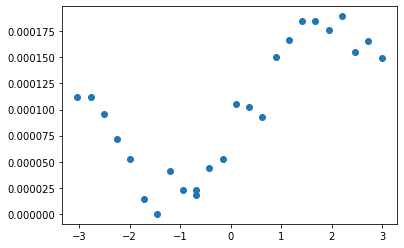

{-0.6827283148765564: (2.3177388356998563e-05, nan),
 -0.4207283148765564: (4.387320950627327e-05, nan),
 -0.15872831487655636: (5.242347833700478e-05, nan),
 0.10327168512344365: (0.00010546081466600299, nan),
 0.36527168512344366: (0.00010199204552918673, nan),
 0.6272716851234437: (9.246336412616074e-05, nan),
 0.8892716851234437: (0.00015070795780047774, nan),
 1.1512716851234437: (0.00016629195306450129, nan),
 1.4132716851234437: (0.00018529975204728544, nan),
 1.6752716851234437: (0.00018478580750524998, nan),
 1.9372716851234437: (0.0001767355133779347, nan),
 2.1992716851234437: (0.00018944195471704006, nan),
 2.4612716851234437: (0.00015488505596295, nan),
 2.7232716851234438: (0.00016614410560578108, nan),
 2.9852716851234438: (0.00014919185196049511, nan),
 -3.0359136220561425: (0.00011161027941852808, nan),
 -2.7739136220561424: (0.0001116425555665046, nan),
 -2.5119136220561424: (9.55392315518111e-05, nan),
 -2.2499136220561424: (7.2144262958318e-05, nan),
 -1.98791362205

In [11]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(htf_ta, 0, False, [669, 670, 29474, 29475], [669, 670, 673, 676], [29476, 29477])

-20608.10824501389


100%|██████████| 10000/10000 [00:12<00:00, 777.05it/s]
INFO:root:Rotating by 0.3579261148330713 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26200000000000156 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.2620000000000027 radians
INFO:root:Rotating by 0.26200000000000356 radians
INFO:root:Rotating by 0.26200000000000356 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179583 radians


0.1817271
-153812.80782219677
-153812.80865140553
-153812.8086039462
-153812.80843394334
-153812.80843047338
-153812.8083271918
-153812.8085604341
-153812.8088553284
-153812.8085096868
-153812.8084356985
-153812.80831168956
-153812.80823878583


INFO:root:Rotating by 0.26199999999999646 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.26200000000000356 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999835 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.2619999999999966 radians
INFO:root:Rotating by 0.2620000000000021 radians


-153812.80861994054
-153812.808401676
-153812.80835225288
-153812.8083166962
-153812.80851952976
-153812.80862677444
-153812.80850448555
-153812.80871485942
-153812.8084548614
-153812.80843445926
-153812.8083351458
-153812.80858951333
-153812.8083807551
raw d: {0.4437270964384079: (-153812.80865140553, nan), 0.7057270964384079: (-153812.8086039462, nan), 0.9677270964384079: (-153812.80843394334, nan), 1.229727096438408: (-153812.80843047338, nan), 1.491727096438408: (-153812.8083271918, nan), 1.753727096438408: (-153812.8085604341, nan), 2.015727096438408: (-153812.8088553284, nan), 2.277727096438408: (-153812.8085096868, nan), 2.539727096438408: (-153812.8084356985, nan), 2.801727096438408: (-153812.80831168956, nan), 3.063727096438408: (-153812.80823878583, nan), -2.957458210741178: (-153812.80861994054, nan), -2.695458210741178: (-153812.808401676, nan), -2.433458210741178: (-153812.80835225288, nan), -2.171458210741178: (-153812.8083166962, nan), -1.9094582107411782: (-153812.80851

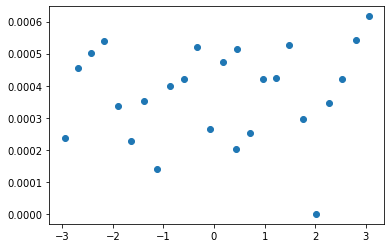

{0.4437270964384079: (0.00020392285659909248, nan),
 0.7057270964384079: (0.00025138218188658357, nan),
 0.9677270964384079: (0.00042138504795730114, nan),
 1.229727096438408: (0.00042485501035116613, nan),
 1.491727096438408: (0.0005281365884002298, nan),
 1.753727096438408: (0.00029489430016838014, nan),
 2.015727096438408: (0.0, nan),
 2.277727096438408: (0.00034564160159789026, nan),
 2.539727096438408: (0.0004196298832539469, nan),
 2.801727096438408: (0.0005436388310045004, nan),
 3.063727096438408: (0.0006165425584185869, nan),
 -2.957458210741178: (0.00023538785171695054, nan),
 -2.695458210741178: (0.0004536523774731904, nan),
 -2.433458210741178: (0.0005030755128245801, nan),
 -2.171458210741178: (0.0005386321863625199, nan),
 -1.9094582107411782: (0.000335798627929762, nan),
 -1.6474582107411782: (0.00022855395218357444, nan),
 -1.3854582107411781: (0.0003508428344503045, nan),
 -1.1234582107411781: (0.00014046896831132472, nan),
 -0.8614582107411781: (0.0004004669899586588,

In [10]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(htf_ta, 1, False,  [669, 670, 673, 674], [669, 670, 673, 674], [675, 678, 679, 680, 681, 682])
